1. Data Aggregation

In [1]:
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np

city_list_chn = '北京、上海、深圳、长沙、天津、杭州、郑州、成都、长春、大连、武汉、济南、南京、无锡、青岛、西安、常州、广州、福州、合肥、昆明、厦门、贵阳、沈阳、南昌、宁波、徐州、重庆、哈尔滨、兰州、乌鲁木齐、南宁、东莞、苏州、石家庄'.split('、')
chn2en = {'东莞': 'Dongguan',   '台州': 'Taizhou',   '南宁': 'Nanning',   '佛山': 'Foshan',   '温州': 'Wenzhou',   '南通': 'Nantong',   '兰州': 'Lanzhou',   '宁波': 'Ningbo',   '南京': 'Nanjing',   '苏州': 'Suzhou',   '太原': 'Taiyuan',   '武汉': 'Wuhan',   '无锡': 'Wuxi',   '郑州': 'Zhengzhou',   '珠海': 'Zhuhai',   '北京': 'Beijing',   '长春': 'Changchun',   '长沙': 'Changsha',   '常州': 'Changzhou',   '成都': 'Chengdu',   '大连': 'Dalian',   '福州': 'Fuzhou',   '广州': 'Guangzhou',   '杭州': 'Hangzhou',   '济南': 'Jinan',   '昆明': 'Kunming',   '青岛': 'Qingdao',   '上海': 'Shanghai',   '深圳': 'Shenzhen',   '石家庄': 'Shijiazhuang',   '天津': 'Tianjin',   '西安': "Xi'an",   '厦门': 'Xiamen',   '徐州': 'Xuzhou',   '沈阳': 'Shenyang',   '南昌': 'Nanchang',   '洛阳': 'Luoyang',   '呼和浩特': 'Hohhot',   '乌鲁木齐': 'Urumqi', '重庆': 'Chongqing', '哈尔滨': 'Harbin', '合肥': 'Hefei', '贵阳': 'Guiyang'}
en2chn = {'Dongguan': '东莞',   'Taizhou': '台州',   'Nanning': '南宁',   'Foshan': '佛山',   'Wenzhou': '温州',   'Nantong': '南通',   'Lanzhou': '兰州',   'Ningbo': '宁波',   'Nanjing': '南京',   'Suzhou': '苏州',   'Taiyuan': '太原',   'Wuhan': '武汉',   'Wuxi': '无锡',   'Zhengzhou': '郑州',   'Zhuhai': '珠海',   'Beijing': '北京',   'Changchun': '长春',   'Changsha': '长沙',   'Changzhou': '常州',   'Chengdu': '成都',   'Dalian': '大连',   'Fuzhou': '福州',   'Guangzhou': '广州',   'Hangzhou': '杭州',   'Jinan': '济南',   'Kunming': '昆明',   'Qingdao': '青岛',   'Shanghai': '上海',   'Shenzhen': '深圳',   'Shijiazhuang': '石家庄',   'Tianjin': '天津',   'Xi': '西安',   'Xiamen': '厦门',   'Xuzhou': '徐州',   'Shenyang': '沈阳',   'Nanchang': '南昌',   'Luoyang': '洛阳',   'Hohhot': '呼和浩特',   'Urumqi': '乌鲁木齐',   "Xi'an": '西安', 'Chongqing': '重庆', 'Harbin': '哈尔滨', 'Hefei': '合肥', 'Guiyang': '贵阳'}
city2remove_list = {}
count = 0

for city_chn in city_list_chn:
    city_en_short = chn2en[city_chn]
    subway_years = pd.read_excel('subway_boundary_file/subway_built_year/subway_years_{}.xlsx'.format(city_en_short), dtype={'connect': str})
    subway_stations_years = pd.read_excel('subway_boundary_file/subway_built_year/subway_stations_years_{}.xlsx'.format(city_en_short), sheet_name=None)

    for row in range(len(subway_years)):
        if type(subway_years.iloc[row]['地铁线路']) == str:
            name = subway_years.iloc[row]['地铁线路']
        else:
            subway_years.loc[row, '地铁线路'] = name

    subway_years['open_time'] = subway_years['开通时间'].apply(lambda x: x.split(' ')[1] if len(x.split(' ')) > 1 else x)
    subway_years['open_month'] = subway_years['open_time'].apply(lambda x: int(x.split('.')[1]))
    subway_years['open_year'] = subway_years['open_time'].apply(lambda x: int(x.split('.')[0]))

    subway2open_year = {}
    for i in range(len(subway_years)):
        if subway_years.iloc[i]['remove'] == 1:
            continue
        line = subway_years.iloc[i]['地铁线路']
        year = subway_years.iloc[i]['open_year']
        if line in subway2open_year:
            if year < subway2open_year[line]:
                subway2open_year[line] = year
        else:
            subway2open_year[line] = year

    remove_subway_list = [line for line in subway2open_year if subway2open_year[line] < 2020]
    
    city2remove_list[city_en_short] = remove_subway_list
    count += len(remove_subway_list)

In [2]:
### gamma calculation
import json
city2ratio = {}

for city_en_short in city2remove_list:
    city_chn = en2chn[city_en_short]
    basic_dir = 'route_api_hours/20240625/{}/result_files'.format(city_en_short)
    with open(basic_dir + '/years_results_overall_months_{}.json'.format(city_en_short), 'r') as f:
        results = json.load(f)
        
    if city_chn not in ['天津', '重庆', '南京', '长春', '大连', '苏州', '青岛']:
        official_stats = pd.read_excel('subway_boundary_file/official_statistics.xlsx', sheet_name=None)
        jinzhanliang_true_list = []
        keyunliang_true_list = []
        licheng_true_list = []

        for year in [2019, 2018, 2017, 2016, 2015]:
            tmp = official_stats[str(year)][official_stats[str(year)]['城市'] == city_chn]
            jinzhanliang_true_list.append(float(tmp['进站量 (万人次)'].sum()) / 365)
            keyunliang_true_list.append(float(tmp['客运量 (万人次)'].sum()) / 365)
            licheng_true_list.append(float(tmp['客运周转量 (万人次公里)'].sum()) / 365)

        jinzhanliang_list = []
        keyunliang_list = []
        licheng_list = []
        for year in [2019, 2018, 2017, 2016, 2015, 2014]:
            jinzhanliang, keyunliang, licheng = 0, 0, 0
            for months in results[str(year)]:
                jinzhanliang += results[str(year)][months]['traffic_num'][0] / (1e4) * len(eval(months))
                keyunliang += np.sum(list(results[str(year)][months]['subway_distribution'].values())) / 1e4 * len(eval(months))
                licheng += results[str(year)][months]['subway_mileage'] / (1e7) * len(eval(months))
            jinzhanliang_list.append(jinzhanliang / 12)
            keyunliang_list.append(keyunliang / 12)
            licheng_list.append(licheng / 12)

        ratio = jinzhanliang_true_list[0] / jinzhanliang_list[0]
        city2ratio[city_en_short] = ratio
    else:
        official_stats = pd.read_excel('subway_boundary_file/official_statistics_2019.xlsx', sheet_name=None)
        jinzhanliang_true_list = []
        keyunliang_true_list = []
        licheng_true_list = []

        for year in [2019, 2018]:
            tmp = official_stats[str(year)][official_stats[str(year)]['城市'] == city_chn]
            keyunliang_true_list.append(float(tmp['客运量 (万人次)'].sum()) / 365)
            licheng_true_list.append(float(tmp['客运周转量 (万人次公里)'].sum()) / 365)

        jinzhanliang_list = []
        keyunliang_list = []
        licheng_list = []
        for year in [2019, 2018]:
            jinzhanliang, keyunliang, licheng = 0, 0, 0
            for months in results[str(year)]:
                jinzhanliang += results[str(year)][months]['traffic_num'][0] / (1e4) * len(eval(months))
                keyunliang += np.sum(list(results[str(year)][months]['subway_distribution'].values())) / 1e4 * len(eval(months))
                licheng += results[str(year)][months]['subway_mileage'] / (1e7) * len(eval(months))
            jinzhanliang_list.append(jinzhanliang / 12)
            keyunliang_list.append(keyunliang / 12)
            licheng_list.append(licheng / 12)
        ratio = keyunliang_true_list[0] / keyunliang_list[0]
        city2ratio[city_en_short] = ratio

2. line-level results summarization

In [ ]:
import openpyxl
import os
import json
from tqdm import tqdm

material = pd.read_excel('subway_construction_info/subway_construction_info.xlsx')
material2carbon = dict(zip(list(material.columns[1:]), material.iloc[0][1:]))

def construction_carbon_cal(station_num, mileage):
    entrance_exit_num, ventilization_num = int(station_num*4.3), int(station_num*4)
    carbon = material2carbon['Station_per_unit(tCO2e/unit)']*station_num + material2carbon['Tunnel_per_km(tCO2e/km)']/1e3*mileage + material2carbon['Entrance_per_unit(tCO2e/unit)']*entrance_exit_num + material2carbon['Ventilization_per_unit((tCO2e/unit))']*ventilization_num
    return carbon

## operation carbon intensity
elec_table = pd.read_excel('real_statistics/electricity_consumption/Electricity_consumption.xlsx')

wb = openpyxl.Workbook()
    
for city_en_short in tqdm(city2remove_list):
    elec_intensity = elec_table[elec_table['City']==city_en_short]['per_mileage_carbon (tCO2/km)'].values[0]
    subway_years = pd.read_excel('subway_boundary_file/subway_built_year/subway_years_{}.xlsx'.format(city_en_short),
                             dtype={'connect': str})
    for row in range(len(subway_years)):
        if type(subway_years.iloc[row]['地铁线路']) == str:
            name = subway_years.iloc[row]['地铁线路']
        else:
            subway_years.loc[row, '地铁线路'] = name

    subway_years['open_time'] = subway_years['开通时间'].apply(lambda x: x.split(' ')[1] if len(x.split(' ')) > 1 else x)
    subway_years['open_month'] = subway_years['open_time'].apply(lambda x: int(x.split('.')[1]))
    subway_years['open_year'] = subway_years['open_time'].apply(lambda x: int(x.split('.')[0]))
        
    basic_dir = 'route_api_hours/20240625/{}/result_files'.format(city_en_short)
    with open(basic_dir+'/years_results_overall_months_{}.json'.format(city_en_short), 'r') as f:
        results_factual = json.load(f)
        
    if city_en_short in ['Beijing', 'Shanghai', 'Chongqing', 'Tianjin']:
        city_en = city_en_short + ' Municipality'
    else:
        city_en = city_en_short
    
    new_sheet = wb.create_sheet(title=city_en_short)
    sheet = wb[city_en_short]
    sheet['A1'] = 'Remove Subway'
    sheet['B1'] = 'Total Construction'
    sheet['C1'] = 'Current Carbon Save'
    sheet['D1'] = 'Current Operation'
    remove_subway_list = city2remove_list[city_en_short]
    idx = 2
    construction_sum = 0
    length_sum = 0
    for i in range(len(remove_subway_list)):
        remove_subway = remove_subway_list[i]
        with open(basic_dir+'/years_results_fenduan_without_{}.json'.format(remove_subway), 'r') as f:
            results = json.load(f)
        subway_table = subway_years[(subway_years['open_year'] < 2020) & (subway_years['地铁线路'] == remove_subway)]
        mileage, station_num = subway_table['mileage'].sum(), subway_table['stationnum'].sum()

        ratio = city2ratio[city_en_short]
        with open(basic_dir+'/years_results_fenduan_without_{}.json'.format(remove_subway), 'r') as f:
            results = json.load(f)
        month = [m for m in results['2019'] if 12 in eval(m)][0]
        carbon_save_value = (results['2019'][month]['carbon'] - results_factual['2019'][month]['carbon']) * ratio / 1e6 
        construction_value = construction_carbon_cal(station_num, mileage)
        current_operation = mileage / 1000 * 1946.94 / 365
        sheet['A{}'.format(idx)] = remove_subway
        sheet['B{}'.format(idx)] = construction_value
        sheet['C{}'.format(idx)] = carbon_save_value
        sheet['D{}'.format(idx)] = current_operation
        idx += 1

wb.save('route_api_hours/20240625/lines_carbon_debt_noncalibrated.xlsx')

100%|██████████| 35/35 [00:00<00:00, 59.29it/s]


3. city-level results summarization

In [ ]:
import openpyxl
import os
from tqdm import tqdm

material = pd.read_excel('subway_construction_info/subway_construction_info.xlsx')
material2carbon = dict(zip(list(material.columns[1:]), material.iloc[0][1:]))

def construction_carbon_cal(station_num, mileage):
    entrance_exit_num, ventilization_num = int(station_num*4.3), int(station_num*4)
    carbon = material2carbon['Station_per_unit(tCO2e/unit)']*station_num + material2carbon['Tunnel_per_km(tCO2e/km)']/1e3*mileage + material2carbon['Entrance_per_unit(tCO2e/unit)']*entrance_exit_num + material2carbon['Ventilization_per_unit((tCO2e/unit))']*ventilization_num
    return carbon

elec_table = pd.read_excel('real_statistics/electricity_consumption/Electricity_consumption.xlsx')

wb = openpyxl.Workbook()
new_sheet = wb.create_sheet(title='Sheet1')
column_names = ['City', 'carbon_save', 'total_construction', 'current_operation']
new_sheet.append(column_names)
row_idx = 1

for city_en_short in tqdm(city2remove_list):
    elec_intensity = elec_table[elec_table['City']==city_en_short]['per_mileage_carbon (tCO2/km)'].values[0]
    subway_years = pd.read_excel('subway_boundary_file/subway_built_year/subway_years_{}.xlsx'.format(city_en_short),
                             dtype={'connect': str})
    for row in range(len(subway_years)):
        if type(subway_years.iloc[row]['地铁线路']) == str:
            name = subway_years.iloc[row]['地铁线路']
        else:
            subway_years.loc[row, '地铁线路'] = name

    subway_years['open_time'] = subway_years['开通时间'].apply(lambda x: x.split(' ')[1] if len(x.split(' ')) > 1 else x)
    subway_years['open_month'] = subway_years['open_time'].apply(lambda x: int(x.split('.')[1]))
    subway_years['open_year'] = subway_years['open_time'].apply(lambda x: int(x.split('.')[0]))

    subway_years = subway_years[(subway_years['open_year']<2020)&(subway_years['open_year']>=2010)]     ### 2010到2020年间的年份
    subway_years = subway_years[subway_years['remove']!=1]
    mileage, station_num = subway_years['mileage'].sum(), subway_years['stationnum'].sum()
        
    basic_dir = 'route_api_hours/20240625/{}/result_files'.format(city_en_short)
    with open(basic_dir+'/years_results_overall_months_{}.json'.format(city_en_short), 'r') as f:
        results_factual = json.load(f)
        
    if chn2en[city_chn] in ['Beijing', 'Shanghai', 'Chongqing', 'Tianjin']:
        city_en = city_en_short + ' Municipality'
    else:
        city_en = city_en_short
        
    with open(basic_dir+'/years_results_overall_counterfactual_{}.json'.format(city_en_short), 'r') as f:
        results = json.load(f)
        
    ratio = city2ratio[city_en_short]
    
    month = [m for m in results_factual['2019'] if 12 in eval(m)][0]
    counterfactual_ratio = np.sum(results_factual['2019'][month]['traffic_num']) / np.sum(results['2019']['traffic_num'])       ### 这部分需要考虑一下
    carbon_save = (results['2019']['carbon'] * counterfactual_ratio - results_factual['2019'][month]['carbon'])*ratio/1e6
    total_construction = construction_carbon_cal(station_num, mileage)
    current_operation = mileage / 1000 * 1946.94 / 365

    data_to_write = [city_en_short, carbon_save, total_construction, current_operation]
    row_idx += 1

    for col, value in enumerate(data_to_write, start=1):
        new_sheet.cell(row=row_idx, column=col, value=value)
    
wb.save('route_api_hours/20240625/city_carbon_debt_noncalibrated.xlsx')

  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:00<00:00, 98.38it/s]


4. city-level analysis

In [5]:
gdp = pd.read_csv('real_statistics/census_data/地区生产总值_当年价格_全市_万元_revised.csv', encoding='gbk')
area = pd.read_csv('real_statistics/census_data/行政区域土地面积_建成区_平方公里_revised.csv', encoding='gbk')
popu_built = pd.read_csv('real_statistics/census_data/年末总人口_市辖区_万人_revised.csv', encoding='gbk')

gdp['Unnamed: 0'] = gdp['Unnamed: 0'].apply(lambda x: x.split('市')[0])
gdp = gdp[gdp['Unnamed: 0'].isin(city_list_chn)]
city2gdp = dict(zip(gdp['Unnamed: 0'], gdp['2019']))
    
area['Unnamed: 0'] = area['Unnamed: 0'].apply(lambda x: x.split('市')[0])
area = area[area['Unnamed: 0'].isin(city_list_chn)]
city2area = dict(zip(area['Unnamed: 0'], area['2019']))

popu_built['Unnamed: 0'] = popu_built['Unnamed: 0'].apply(lambda x:x.split('市')[0])
popu_built = popu_built[popu_built['Unnamed: 0'].isin(city_list_chn)]
city2popu_built = dict(zip(popu_built['Unnamed: 0'], popu_built['2019']))

city_indicator = pd.read_excel('route_api_hours/city_basic_attributes.xlsx')
city2popu = dict(zip(city_indicator['city'], city_indicator['Population']))

In [6]:
# congestion data load
congestion_2022 = np.loadtxt('supplementary_data/congestion_2022.txt', dtype=str, delimiter=',')

city2congestion = {}

for idx in range(1, 101):
    city = congestion_2022[2*idx-2].split('·')[1]
    congestion = float(congestion_2022[2*idx-1])
    city2congestion[city] = congestion

# census data load
city_area = pd.read_csv('supplementary_data/YearBook/09_土地面积_市区.csv',encoding='gbk')
city_built_area = pd.read_csv('supplementary_data/YearBook/10_土地面积_建成区.csv',encoding='gbk')
city_popu_density = pd.read_csv('supplementary_data/YearBook/14_人口密度_地区.csv',encoding='gbk')
road_area = pd.read_csv('supplementary_data/YearBook/38_年末实有铺装道路面积.csv',encoding='gbk')
city_bus = pd.read_excel('supplementary_data/citybus.xlsx')

city_area['City'] = city_area['城市'].apply(lambda x: x[:-1])
city_built_area['City'] = city_built_area['城市'].apply(lambda x: x[:-1])
city_popu_density['City'] = city_popu_density['城市'].apply(lambda x: x[:-1])
road_area['City'] = road_area['城市'].apply(lambda x: x[:-1])
city_bus['City'] = city_bus['City'].apply(lambda x: x[:-1])
city2builtarea = dict(zip(city_built_area['City'], city_built_area['值']))
city2popudensity = dict(zip(city_popu_density['City'], city_popu_density['值']))
city2roadarea = dict(zip(road_area['City'], road_area['值']))
city2bus = dict(zip(city_bus['City'], city_bus['Number of Buses']))
city2busflow = dict(zip(city_bus['City'], city_bus['Total annual volume of bus passengers']))

In [15]:
import pandas as pd
en2chn = {'Dongguan': '东莞',   'Taizhou': '台州',   'Nanning': '南宁',   'Foshan': '佛山',   'Wenzhou': '温州',   'Nantong': '南通',   'Lanzhou': '兰州',   'Ningbo': '宁波',   'Nanjing': '南京',   'Suzhou': '苏州',   'Taiyuan': '太原',   'Wuhan': '武汉',   'Wuxi': '无锡',   'Zhengzhou': '郑州',   'Zhuhai': '珠海',   'Beijing': '北京',   'Changchun': '长春',   'Changsha': '长沙',   'Changzhou': '常州',   'Chengdu': '成都',   'Dalian': '大连',   'Fuzhou': '福州',   'Guangzhou': '广州',   'Hangzhou': '杭州',   'Jinan': '济南',   'Kunming': '昆明',   'Qingdao': '青岛',   'Shanghai': '上海',   'Shenzhen': '深圳',   'Shijiazhuang': '石家庄',   'Tianjin': '天津',   'Xi': '西安',   'Xiamen': '厦门',   'Xuzhou': '徐州',   'Shenyang': '沈阳',   'Nanchang': '南昌',   'Luoyang': '洛阳',   'Hohhot': '呼和浩特',   'Urumqi': '乌鲁木齐',   "Xi'an": '西安', 'Chongqing': '重庆', 'Harbin': '哈尔滨', 'Hefei': '合肥', 'Guiyang': '贵阳'}

city_debt = pd.read_excel('route_api_hours/20240625/city_carbon_debt_noncalibrated.xlsx', sheet_name=None)
city_debt['Sheet1']['carbon_save_value'] = city_debt['Sheet1']['carbon_save']-city_debt['Sheet1']['current_operation']

city_debt['Sheet1']['Yearbook_area'] = city_debt['Sheet1']['City'].apply(lambda x: city2area[en2chn[x]] if en2chn[x] in city2area else np.nan)
city_debt['Sheet1']['Yearbook_built_area'] = city_debt['Sheet1']['City'].apply(lambda x: city2builtarea[en2chn[x]] if en2chn[x] in city2builtarea else np.nan)
city_debt['Sheet1']['Yearbook_popu_density'] = city_debt['Sheet1']['City'].apply(lambda x: city2popudensity[en2chn[x]] if en2chn[x] in city2popudensity else np.nan)
city_debt['Sheet1']['Yearbook_popu_built'] = city_debt['Sheet1']['City'].apply(lambda x: city2popu_built[en2chn[x]] if en2chn[x] in city2popu_built else np.nan)
city_debt['Sheet1']['Yearbook_road_area'] = city_debt['Sheet1']['City'].apply(lambda x: city2roadarea[en2chn[x]] if en2chn[x] in city2roadarea else np.nan)
city_debt['Sheet1']['Yearbook_bus'] = city_debt['Sheet1']['City'].apply(lambda x: city2bus[en2chn[x]] if en2chn[x] in city2bus else np.nan)
city_debt['Sheet1']['Yearbook_bus_flow'] = city_debt['Sheet1']['City'].apply(lambda x: city2busflow[en2chn[x]] if en2chn[x] in city2busflow else np.nan)
city_debt['Sheet1']['Yearbook_popu'] = city_debt['Sheet1']['City'].apply(lambda x: city2popu[en2chn[x]] if en2chn[x] in city2popu else np.nan)
city_debt['Sheet1']['Yearbook_GDP'] = city_debt['Sheet1']['City'].apply(lambda x: city2gdp[en2chn[x]] if en2chn[x] in city2gdp else np.nan)
city_debt['Sheet1']['Congestion'] = city_debt['Sheet1']['City'].apply(lambda x: city2congestion[en2chn[x]] if en2chn[x] in city2popu else np.nan)

In [16]:
class_list = {'First-tier Cities': ['Beijing', 'Shanghai', 'Shenzhen', 'Guangzhou'], 'New First-tier Cities':['Tianjin', 'Changsha', 'Hangzhou','Dongguan', 'Ningbo', 'Zhengzhou', 'Chengdu','Wuhan','Nanjing','Qingdao', "Xi'an", 'Hefei','Chongqing', 'Suzhou'], 
 'Second-tier Cities':['Kunming', 'Shenyang', 'Harbin', 'Xuzhou', 'Xiamen', 'Fuzhou', 'Fuzhou', 'Lanzhou', 'Changzhou', 'Nanchang', 'Guiyang', 'Jinan', 'Wuxi', 'Dalian', 'Changchun', 'Shijiazhuang', 'Nanning'], 'Third-tier Cities':['Urumqi']}

for name in city_debt['Sheet1']['City'].unique():
    count = 0
    for class_ in class_list:
        if name in class_list[class_]:
            count = 1
    if count == 0:
        print(name)

name2class = {}
for class_ in class_list:
    for name in class_list[class_]:
        name2class[name]=class_

city_debt['Sheet1']['city_class'] = city_debt['Sheet1']['City'].apply(lambda x: name2class[x])
tmp = city_debt['Sheet1'][city_debt['Sheet1']['city_class'].isin(['Second-tier Cities', 'Third-tier Cities'])]
city_debt['Sheet1']['break_even_years'] = city_debt['Sheet1']['total_construction']/city_debt['Sheet1']['carbon_save_value']/365


In [17]:
### subway line indicator
city_indicator = pd.read_excel('route_api_hours/city_indicator.xlsx')
line_indicator = pd.read_excel('route_api_hours/line_indicator_0625.xlsx')

city2round = line_indicator.groupby('city')['round'].agg(sum).to_dict()
city2citylinenum = dict(zip(city_indicator['city'], city_indicator['subway_line_num']))
city2citystationnum = dict(zip(city_indicator['city'], city_indicator['subway_station_num']))
city2citylinelength = dict(zip(city_indicator['city'], city_indicator['subway_line_length']))
city2citylineopenyear = dict(zip(city_indicator['city'], city_indicator['subway_open_year']))
city2citystationexchangenum = dict(zip(city_indicator['city'], city_indicator['subway_station_exchange_num']))
city2citynewlinelength = dict(zip(city_indicator['city'], city_indicator['subway_new_line_length']))

city_debt['Sheet1']['city_line_num'] = city_debt['Sheet1']['City'].apply(lambda x: city2citylinenum[x])
city_debt['Sheet1']['city_station_num'] = city_debt['Sheet1']['City'].apply(lambda x: city2citystationnum[x])
city_debt['Sheet1']['city_line_length'] = city_debt['Sheet1']['City'].apply(lambda x: city2citylinelength[x])
city_debt['Sheet1']['city_line_open_year'] = city_debt['Sheet1']['City'].apply(lambda x: city2citylineopenyear[x])
city_debt['Sheet1']['city_station_exchange_num'] = city_debt['Sheet1']['City'].apply(lambda x: city2citystationexchangenum[x])
city_debt['Sheet1']['city_new_line_length'] = city_debt['Sheet1']['City'].apply(lambda x: city2citynewlinelength[x])
city_debt['Sheet1']['round'] = city_debt['Sheet1']['City'].apply(lambda x: city2round[x])

In [18]:
import pandas as pd
carbon_debt_lines = pd.read_excel('route_api_hours/20240625/lines_carbon_debt_noncalibrated.xlsx', sheet_name=None)
excel_list = []
for city in carbon_debt_lines:
    carbon_debt_lines[city]['city'] = city
    excel_list.append(carbon_debt_lines[city])

carbon_debt_lines = pd.concat(excel_list, axis=0)

carbon_debt_lines.columns = ['city', 'line', 'Total Construction', 'Current Carbon Save', 'Current Operation']
carbon_debt_lines['carbon_save_rate'] = (carbon_debt_lines['Current Carbon Save']-carbon_debt_lines['Current Operation'])/carbon_debt_lines['Total Construction']

city_line_indicator = pd.read_excel('route_api_hours/line_indicator_0625.xlsx')

carbon_debt_lines = pd.merge(carbon_debt_lines, city_line_indicator, on=['city', 'line'], how='outer')
carbon_debt_lines['carbon_save_rate_mileage'] = (carbon_debt_lines['Current Carbon Save']-carbon_debt_lines['Current Operation'])/carbon_debt_lines['subway_line_mileage']*1e3
carbon_debt_lines = carbon_debt_lines.dropna()

carbon_debt_lines['break_even_time'] = carbon_debt_lines['Total Construction']/(carbon_debt_lines['Current Carbon Save']-carbon_debt_lines['Current Operation'])/365

In [19]:
class_list = {'First-tier Cities': ['Beijing', 'Shanghai', 'Shenzhen', 'Guangzhou'], 'New First-tier Cities':['Tianjin', 'Changsha', 'Hangzhou','Dongguan', 'Ningbo', 'Zhengzhou', 'Chengdu','Wuhan','Nanjing','Qingdao', "Xi'an", 'Hefei','Chongqing', 'Suzhou'], 
 'Second-tier Cities':['Kunming', 'Shenyang', 'Harbin', 'Xuzhou', 'Xiamen', 'Fuzhou', 'Fuzhou', 'Lanzhou', 'Changzhou', 'Nanchang', 'Guiyang', 'Jinan', 'Wuxi', 'Dalian', 'Changchun', 'Shijiazhuang', 'Nanning'], 'Third-tier Cities':['Urumqi']}

for name in city_debt['Sheet1']['City'].unique():
    count = 0
    for class_ in class_list:
        if name in class_list[class_]:
            count = 1
    if count == 0:
        print(name)

name2class = {}
for class_ in class_list:
    for name in class_list[class_]:
        name2class[name]=class_

carbon_debt_lines['city_class'] = carbon_debt_lines['city'].apply(lambda x: name2class[x])
carbon_debt_lines_breakeven = carbon_debt_lines[carbon_debt_lines['break_even_time']>=0]

/tmp/ipykernel_1308368/979747617.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carbon_debt_lines_breakeven['break_even_time'] = carbon_debt_lines_breakeven['break_even_time'].apply(lambda x: min(x, 65))


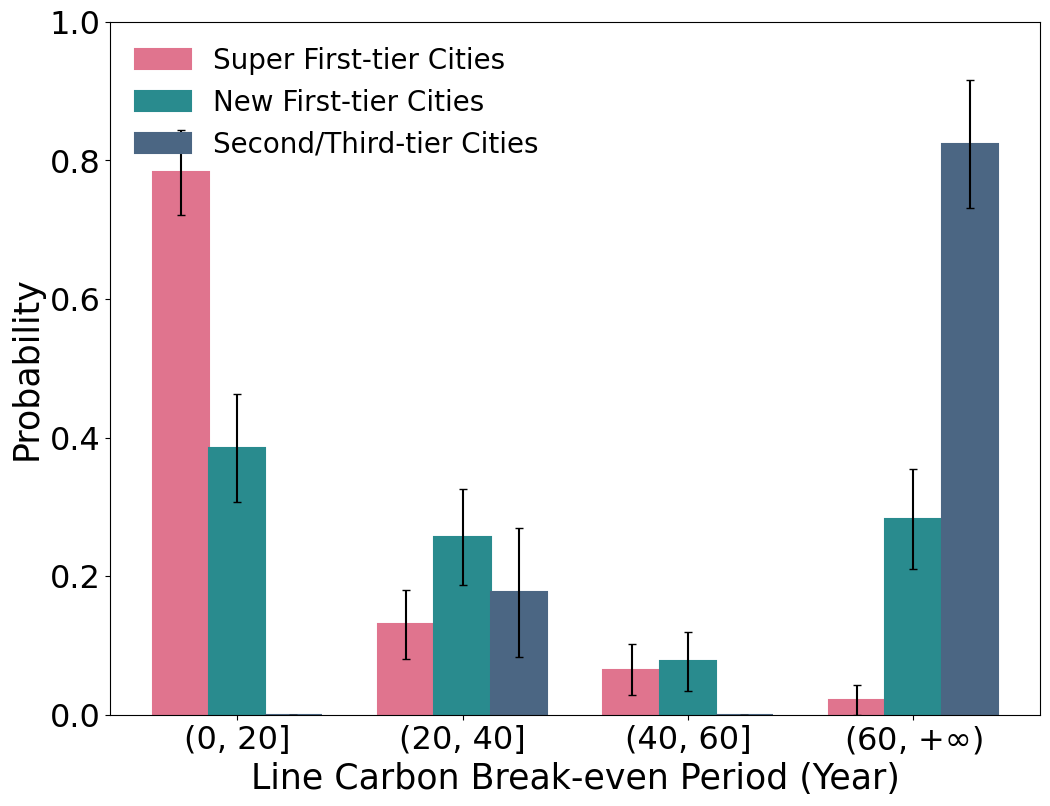

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import rcParams
import math

rcParams['font.sans-serif'] = ['DejaVu Sans']
rcParams['font.family'] = 'sans-serif'

plt.figure(figsize=(12, 9))


carbon_debt_lines_breakeven['break_even_time'] = carbon_debt_lines_breakeven['break_even_time'].apply(lambda x: min(x, 65))

bins = list(range(0, 81, 20))

first_tier_offset = carbon_debt_lines_breakeven[carbon_debt_lines_breakeven['city_class'] == 'First-tier Cities'].copy()
new_first_tier_offset = carbon_debt_lines_breakeven[carbon_debt_lines_breakeven['city_class'] == 'New First-tier Cities'].copy()
second_tier_offset = carbon_debt_lines_breakeven[carbon_debt_lines_breakeven['city_class'].isin(['Second-tier Cities', 'Third-tier Cities'])].copy()

first_tier_hist, _ = np.histogram(first_tier_offset['break_even_time'], bins=bins)
new_first_tier_hist, _ = np.histogram(new_first_tier_offset['break_even_time'], bins=bins)
second_tier_hist, _ = np.histogram(second_tier_offset['break_even_time'], bins=bins)

first_tier_prob = first_tier_hist / first_tier_hist.sum()
new_first_tier_prob = new_first_tier_hist / new_first_tier_hist.sum()
second_tier_prob = second_tier_hist / second_tier_hist.sum()

first_tier_se = np.sqrt(first_tier_prob * (1 - first_tier_prob) / first_tier_hist.sum())
new_first_tier_se = np.sqrt(new_first_tier_prob * (1 - new_first_tier_prob) / new_first_tier_hist.sum())
second_tier_se = np.sqrt(second_tier_prob * (1 - second_tier_prob) / second_tier_hist.sum())

bar_width = 5 

first_tier_positions = np.array(bins[:-1]) - bar_width * 1
new_first_tier_positions = np.array(bins[:-1]) + bar_width * 0
second_tier_positions = np.array(bins[:-1]) + bar_width * 1

plt.bar(first_tier_positions, first_tier_prob, yerr=first_tier_se, width=bar_width, color='#e0748e', label='Super First-tier Cities', alpha=1, edgecolor='#e0748e', linewidth=1.5, capsize=3)
plt.bar(new_first_tier_positions, new_first_tier_prob, yerr=new_first_tier_se, width=bar_width, color='#298b8e', label='New First-tier Cities', alpha=1,edgecolor='#298b8e', linewidth=1.5, capsize=3)
plt.bar(second_tier_positions, second_tier_prob, yerr=second_tier_se, width=bar_width, color='#4b6683', label='Second/Third-tier Cities', alpha=1, edgecolor='#4b6683', linewidth=1.5, capsize=3)

plt.legend(fontsize=20, frameon=False, loc='upper left')
plt.xlabel('Line Carbon Break-even Period (Year)', fontsize=25)
plt.ylabel('Probability', fontsize=25)
plt.ylim(0, 1)

plt.xticks(bins[:-1], ['(0, 20]', '(20, 40]', '(40, 60]', '(60, +$\\infty$)'])
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.show()


/tmp/ipykernel_1308368/3990930693.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carbon_debt_lines_breakeven['break_even_time'] = carbon_debt_lines_breakeven['break_even_time'].apply(lambda x: min(x, 65))


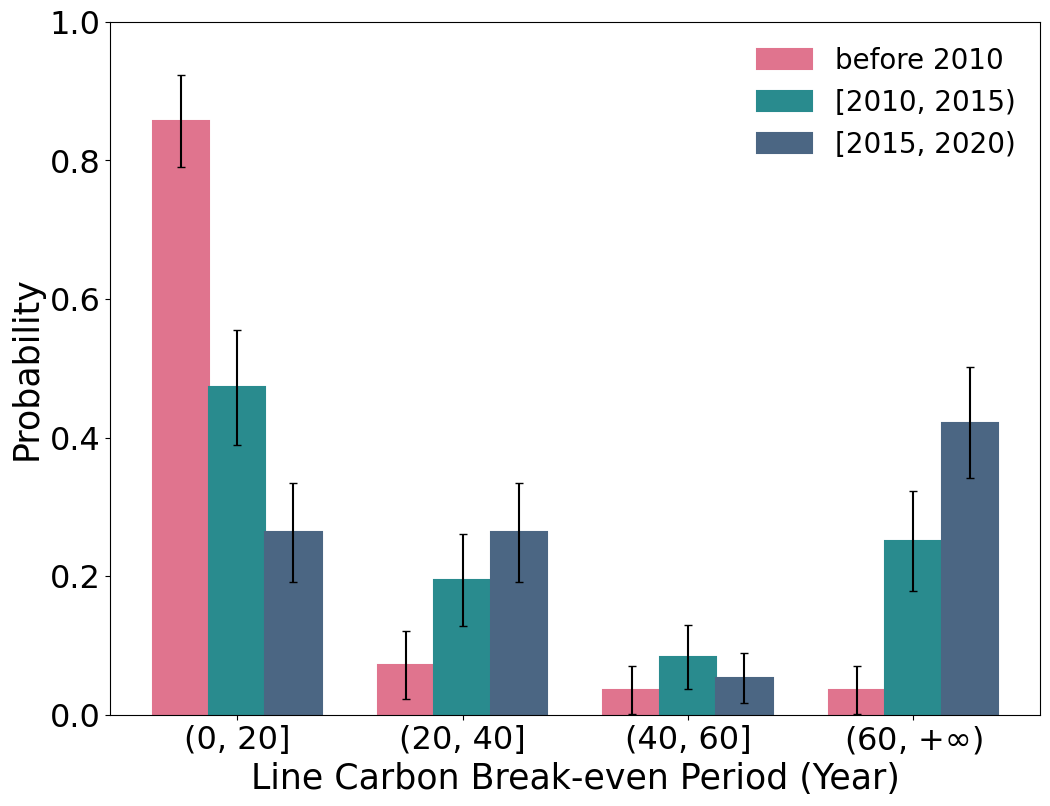

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import rcParams

rcParams['font.sans-serif'] = ['DejaVu Sans']
rcParams['font.family'] = 'sans-serif'

plt.figure(figsize=(12, 9))

carbon_debt_lines_breakeven['break_even_time'] = carbon_debt_lines_breakeven['break_even_time'].apply(lambda x: min(x, 65))

bins = list(range(0, 81, 20))

first_tier_offset = carbon_debt_lines_breakeven[carbon_debt_lines_breakeven['open_year'] < 2010].copy()
new_first_tier_offset = carbon_debt_lines_breakeven[(carbon_debt_lines_breakeven['open_year'] < 2015) & (carbon_debt_lines_breakeven['open_year'] >= 2010)].copy()
second_tier_offset = carbon_debt_lines_breakeven[(carbon_debt_lines_breakeven['open_year'] < 2020) & (carbon_debt_lines_breakeven['open_year'] >= 2015)].copy()

first_tier_hist, _ = np.histogram(first_tier_offset['break_even_time'], bins=bins)
new_first_tier_hist, _ = np.histogram(new_first_tier_offset['break_even_time'], bins=bins)
second_tier_hist, _ = np.histogram(second_tier_offset['break_even_time'], bins=bins)

first_tier_prob = first_tier_hist / first_tier_hist.sum()
new_first_tier_prob = new_first_tier_hist / new_first_tier_hist.sum()
second_tier_prob = second_tier_hist / second_tier_hist.sum()

first_tier_se = np.sqrt(first_tier_prob * (1 - first_tier_prob) / first_tier_hist.sum())
new_first_tier_se = np.sqrt(new_first_tier_prob * (1 - new_first_tier_prob) / new_first_tier_hist.sum())
second_tier_se = np.sqrt(second_tier_prob * (1 - second_tier_prob) / second_tier_hist.sum())

bar_width = 5  

first_tier_positions = np.array(bins[:-1]) - bar_width * 1
new_first_tier_positions = np.array(bins[:-1]) + bar_width * 0
second_tier_positions = np.array(bins[:-1]) + bar_width * 1

plt.bar(first_tier_positions, first_tier_prob, yerr=first_tier_se, width=bar_width, color='#e0748e', label='before 2010', alpha=1, edgecolor='#e0748e', linewidth=1.5, capsize=3)
plt.bar(new_first_tier_positions, new_first_tier_prob, yerr=new_first_tier_se, width=bar_width, color='#298b8e', label='[2010, 2015)', alpha=1,edgecolor='#298b8e', linewidth=1.5, capsize=3)
plt.bar(second_tier_positions, second_tier_prob, yerr=second_tier_se, width=bar_width, color='#4b6683', label='[2015, 2020)', alpha=1, edgecolor='#4b6683', linewidth=1.5, capsize=3)

plt.legend(fontsize=20, frameon=False, loc='upper right')
plt.xlabel('Line Carbon Break-even Period (Year)', fontsize=25)
plt.ylabel('Probability', fontsize=25)

plt.xticks(bins[:-1], ['(0, 20]', '(20, 40]', '(40, 60]', '(60, +$\\infty$)'])
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.ylim(0, 1)
plt.show()


In [22]:
class_list = {'First-tier Cities': ['Beijing', 'Shanghai', 'Shenzhen', 'Guangzhou'], 'New First-tier Cities':['Tianjin', 'Changsha', 'Hangzhou','Dongguan', 'Ningbo', 'Zhengzhou', 'Chengdu','Wuhan','Nanjing','Qingdao', "Xi'an", 'Hefei','Chongqing', 'Suzhou'], 
 'Second-tier Cities':['Kunming', 'Shenyang', 'Harbin', 'Xuzhou', 'Xiamen', 'Fuzhou', 'Fuzhou', 'Lanzhou', 'Changzhou', 'Nanchang', 'Guiyang', 'Jinan', 'Wuxi', 'Dalian', 'Changchun', 'Shijiazhuang', 'Nanning'], 'Third-tier Cities':['Urumqi']}

for name in city_debt['Sheet1']['City'].unique():
    count = 0
    for class_ in class_list:
        if name in class_list[class_]:
            count = 1
    if count == 0:
        print(name)

name2class = {}
for class_ in class_list:
    for name in class_list[class_]:
        name2class[name]=class_

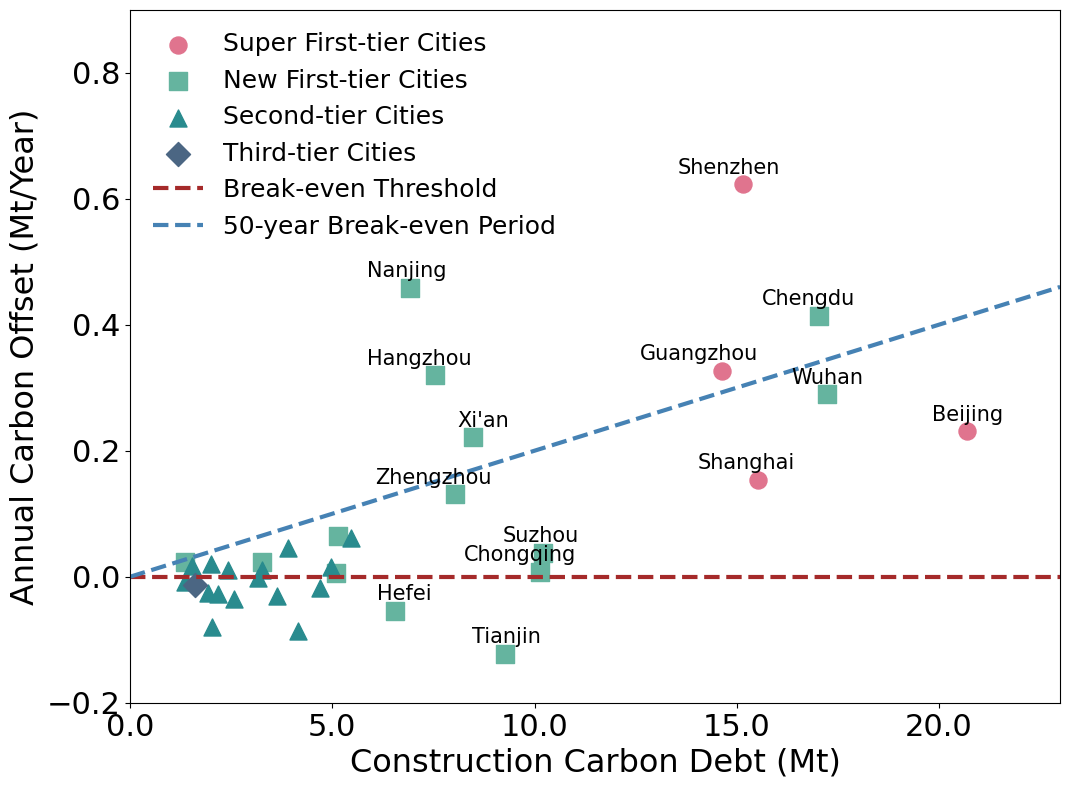

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

tmp = city_debt['Sheet1']
x = tmp['total_construction']/(1e6)
y = tmp['carbon_save_value'] * 365/(1e6)
names = tmp['City']
classes = tmp['City'].apply(lambda x: name2class[x])

class_to_marker = {
    'First-tier Cities': 'o',
    'New First-tier Cities': 's',
    'Second-tier Cities': '^',
    'Third-tier Cities': 'D'
}

class_to_color = {
    'First-tier Cities': '#e0748e',
    'New First-tier Cities': '#65b49f',
    'Second-tier Cities': '#298b8e',
    'Third-tier Cities': '#4b6683'
}

class_key = {'First-tier Cities': 'Super First-tier Cities',
             'New First-tier Cities': 'New First-tier Cities',
             'Second-tier Cities': 'Second-tier Cities',
             'Third-tier Cities': 'Third-tier Cities'}

plt.figure(figsize=(12, 9))

for class_name in class_to_marker.keys():
    class_mask = (classes == class_name)
    plt.scatter(
        x[class_mask], 
        y[class_mask], 
        marker=class_to_marker[class_name], 
        color=class_to_color[class_name], 
        alpha=1, 
        s=150, 
        label=class_key[class_name]
    )

plt.axhline(y=0, color='brown', linestyle='--', label='Break-even Threshold', linewidth=3)

x_values = np.linspace(0, 23, 100)
y_values = 1/50 * x_values
plt.plot(x_values, y_values, color='steelblue', linestyle='--', label='50-year Break-even Period', linewidth=3)

for i, name in enumerate(names):
    xi = x[i]
    yi = y[i]
    if xi <= 6 and yi <= 0.1:
        continue
    plt.text(xi + 0.9, yi + 0.017, name, fontsize=15, ha='right')
    i += 1

plt.xlabel('Construction Carbon Debt (Mt)', fontsize=23)
plt.ylabel('Annual Carbon Offset (Mt/Year)', fontsize=23)

plt.ylim(-0.2,0.9)
plt.xlim(0, 23)

plt.xticks(np.linspace(0, 20, 5), np.linspace(0, 20, 5), fontsize=22)
plt.yticks(fontsize=22)

plt.legend(fontsize=18, frameon=False, loc='upper left')
plt.show()

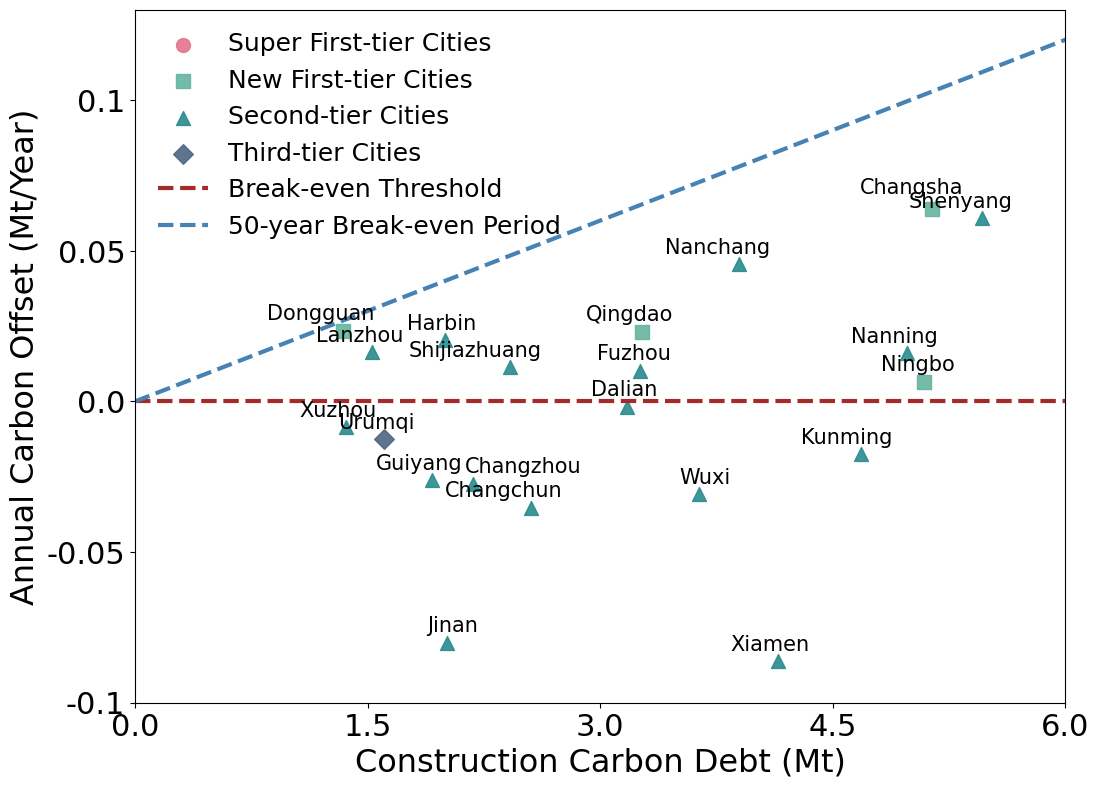

In [24]:
tmp = city_debt['Sheet1']
tmp = tmp[tmp['carbon_save_value']<1.3e5]
x = tmp['total_construction']/(1e6)
y = tmp['carbon_save_value'] * 365/(1e6)
names = tmp['City']
classes = tmp['City'].apply(lambda x: name2class[x])

class_to_marker = {
    'First-tier Cities': 'o',
    'New First-tier Cities': 's',
    'Second-tier Cities': '^',
    'Third-tier Cities': 'D'
}

class_to_color = {
    'First-tier Cities': '#e0748e',
    'New First-tier Cities': '#65b49f',
    'Second-tier Cities': '#298b8e',
    'Third-tier Cities': '#4b6683'
}

class_key = {'First-tier Cities': 'Super First-tier Cities',
             'New First-tier Cities': 'New First-tier Cities',
             'Second-tier Cities': 'Second-tier Cities',
             'Third-tier Cities': 'Third-tier Cities'}

plt.figure(figsize=(12, 9))

for class_name in class_to_marker.keys():
    class_mask = (classes == class_name)
    plt.scatter(
        x[class_mask], 
        y[class_mask], 
        marker=class_to_marker[class_name], 
        color=class_to_color[class_name], 
        alpha=0.9, 
        s=100, 
        label=class_key[class_name]
    )

plt.axhline(y=0, color='brown', linestyle='--', label='Break-even Threshold', linewidth=3)

x_values = np.linspace(0, max(x), 100)
y_values = 1/50 * x_values
plt.plot(x_values, y_values, color='steelblue', linestyle='--', label='50-year Break-even Period', linewidth=3)

for i, name in enumerate(names):
    if name == 'Guiyang':
        xi = x[i]
        yi = y[i]
        if yi > 0.13 or xi > 6:
            continue
        plt.text(xi+0.2, yi+0.0035, name, fontsize=15, ha='right')
        i += 1
    elif name == 'Changzhou':
        xi = x[i]
        yi = y[i]
        if yi > 0.13 or xi > 6:
            continue
        plt.text(xi + 0.7, yi+0.0035, name, fontsize=15, ha='right')
        i += 1   
    elif name == 'Changsha':
        xi = x[i]
        yi = y[i]
        if yi > 0.13 or xi > 6:
            continue
        plt.text(xi + 0.2, yi+0.005, name, fontsize=15, ha='right')
        i += 1  
    else: 
        xi = x[i]
        yi = y[i]
        if yi > 0.13 or xi > 6:
            continue
        plt.text(xi + 0.2, yi+0.0035, name, fontsize=15, ha='right')
        i += 1

plt.ylim(-0.1, 0.13)
plt.xlim(0, 6)

plt.xlabel('Construction Carbon Debt (Mt)', fontsize=23)
plt.ylabel('Annual Carbon Offset (Mt/Year)', fontsize=23)

plt.xticks(np.linspace(0, 6, 5), np.linspace(0, 6, 5), fontsize=22)
plt.yticks(np.linspace(-0.1, 0.1, 5), [round(x, 2) for x in np.linspace(-0.1, 0.1, 5)], fontsize=22)

plt.legend(fontsize=18, frameon=False, loc='upper left')

plt.show()


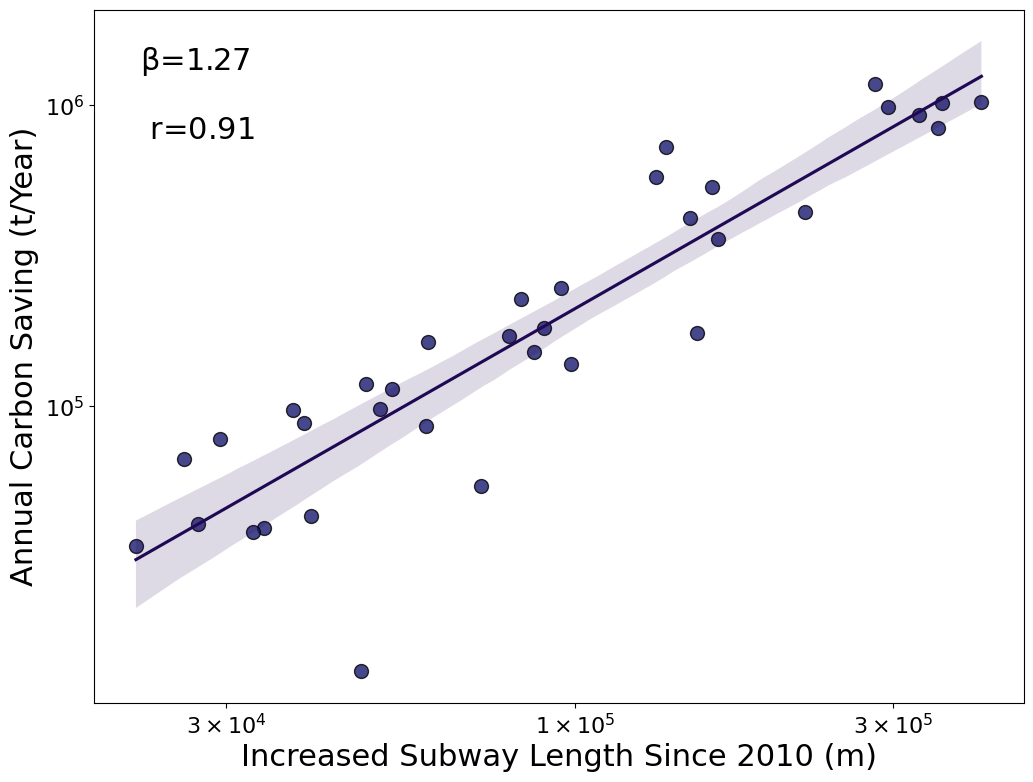

In [25]:
### scaling
import seaborn as sns
from scipy.stats import linregress
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams
import math

rcParams['font.sans-serif'] = ['DejaVu Sans']
rcParams['font.family'] = 'sans-serif'

x = city_debt['Sheet1']['city_new_line_length']
y = city_debt['Sheet1']['carbon_save'].values*365

log_x = np.log10(x)
log_y = np.log10(y)

plt.figure(figsize=(12, 9))

slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)

sns.regplot(x=log_x, y=log_y, scatter=True, label=f'Fit (Exponent={slope:.2f}, r-value={r_value:.2f})',
            scatter_kws={'s': 100, 'edgecolor': 'black', 'linewidth': 1, 'color': '#191970'},
            line_kws={'color': '#1f0954'})

plt.xlabel('Increased Subway Length Since 2010 (m)', fontsize=22)
plt.ylabel('Annual Carbon Saving (t/Year)', fontsize=22)

def log_format(x, pos):
    x = 10**x
    a = x / (10 ** int(np.log10(x)))
    b = int(np.log10(x))
    return f'${a:.0f} \\times 10^{{{b}}}$'

xt = [3*10**4, 10**5, 3*10**5]
xt = [np.log10(m) for m in xt]
plt.xticks(xt, fontsize=16)
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_format))

def log_format_2(x, pos):
    return f'$10^{{{round(x)}}}$'

yt = np.linspace(5, 6, 2)
plt.yticks(yt, fontsize=16)
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_format_2))

plt.text(0.05, 0.95, f'$\\beta$={slope:.2f}\n \n $r$={r_value:.2f}', 
         transform=plt.gca().transAxes, fontsize=22, verticalalignment='top')

plt.show()

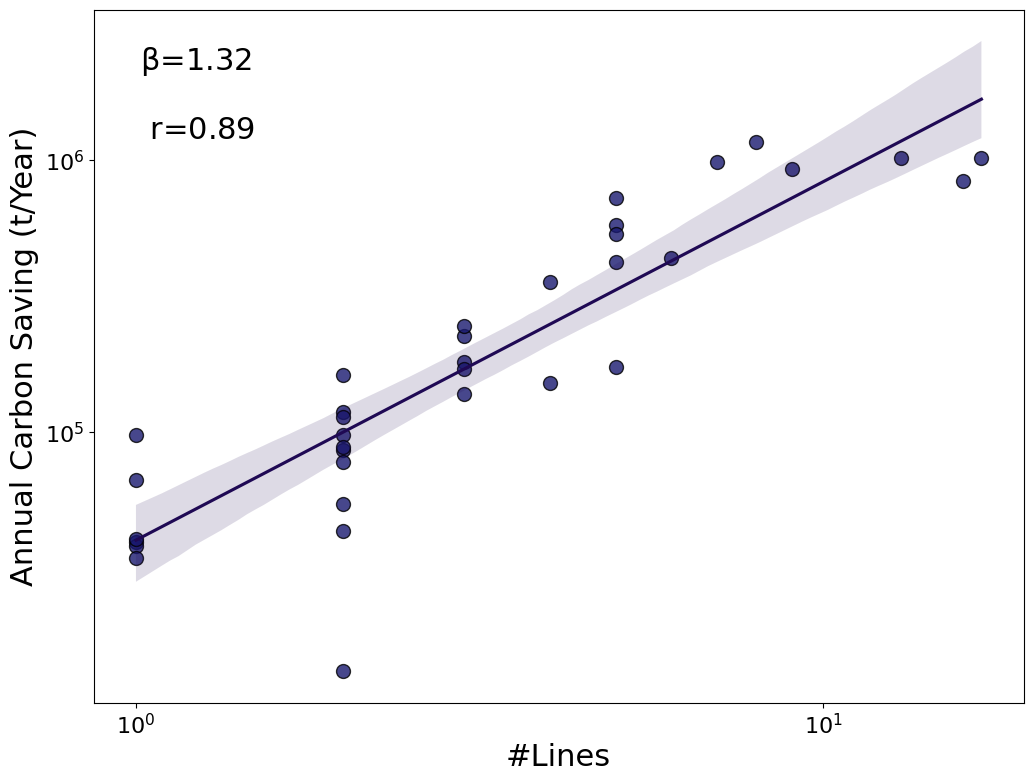

In [26]:
### scaling
import seaborn as sns
from scipy.stats import linregress
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams
import math

rcParams['font.sans-serif'] = ['DejaVu Sans']
rcParams['font.family'] = 'sans-serif'

x = city_debt['Sheet1']['city_line_num']
y = city_debt['Sheet1']['carbon_save'].values*365

log_x = np.log10(x)
log_y = np.log10(y)

plt.figure(figsize=(12, 9))

slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)

sns.regplot(x=log_x, y=log_y, scatter=True, label=f'Fit (Exponent={slope:.2f}, r-value={r_value:.2f})',
            scatter_kws={'s': 100, 'edgecolor': 'black', 'linewidth': 1, 'color': '#191970'},
            line_kws={'color': '#1f0954'})

plt.xlabel('#Lines', fontsize=22)
plt.ylabel('Annual Carbon Saving (t/Year)', fontsize=22)

def log_format(x, pos):
    return f'$10^{{{round(x)}}}$'

xt = np.linspace(0, 1, 2)
plt.xticks(xt, fontsize=16)
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_format))

yt = np.linspace(5, 6, 2)
plt.yticks(yt, fontsize=16)
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_format))

plt.text(0.05, 0.95, f'$\\beta$={slope:.2f}\n \n $r$={r_value:.2f}', 
         transform=plt.gca().transAxes, fontsize=22, verticalalignment='top')

plt.show()

Text(0.05, 0.95, '$\\beta$=1.85\n \n $r$=0.73')

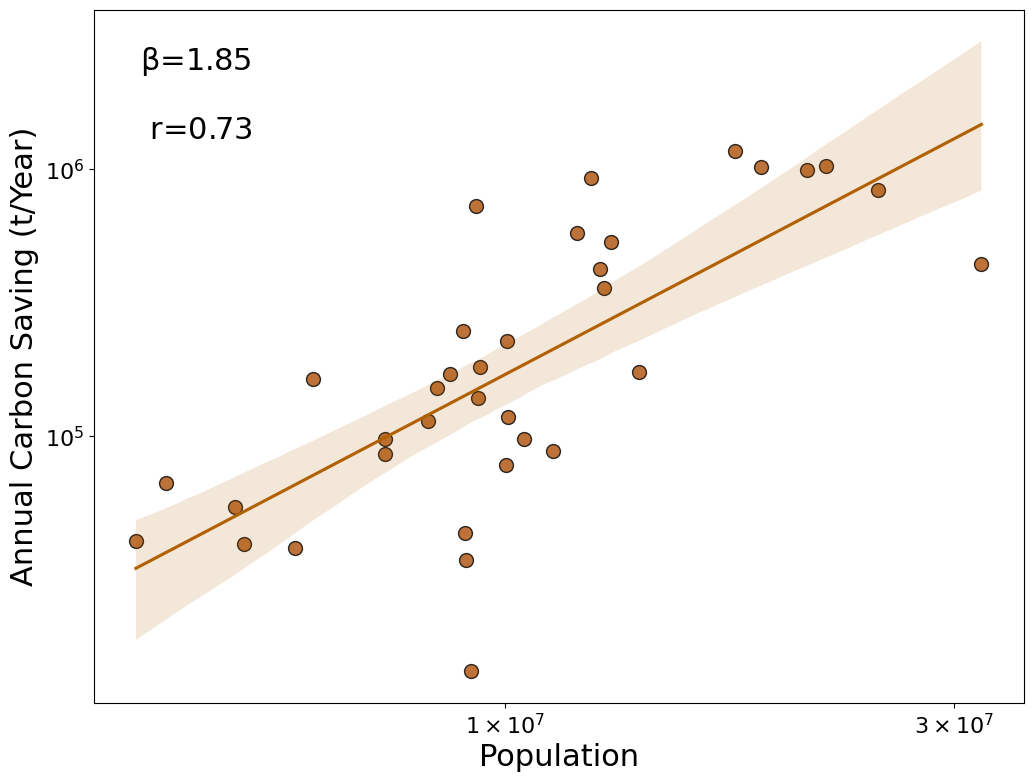

In [27]:
### scaling
import seaborn as sns
from scipy.stats import linregress
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams
import math

rcParams['font.sans-serif'] = ['DejaVu Sans']
rcParams['font.family'] = 'sans-serif'

x = city_debt['Sheet1'][city_debt['Sheet1']['Yearbook_popu']>0]['Yearbook_popu']
y = city_debt['Sheet1'][city_debt['Sheet1']['Yearbook_popu']>0]['carbon_save'].values*365

log_x = np.log10(x)
log_y = np.log10(y)

plt.figure(figsize=(12, 9))

slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)

sns.regplot(x=log_x, y=log_y, scatter=True, label=f'Fit (Exponent={slope:.2f}, r-value={r_value:.2f})',
            scatter_kws={'s': 100, 'edgecolor': 'black', 'linewidth': 1, 'color': '#ac4f06'},
            line_kws={'color': '#b16002'})

plt.xlabel('Population', fontsize=22)
plt.ylabel('Annual Carbon Saving (t/Year)', fontsize=22)

def log_format(x, pos):
    x = 10**x
    a = x / (10 ** int(np.log10(x)))
    b = int(np.log10(x))
    return f'${a:.0f} \\times 10^{{{b}}}$'

xt = [10**7, 3*10**7]
xt = [np.log10(m) for m in xt]
plt.xticks(xt, fontsize=16)
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_format))

def log_format_2(x, pos):
    return f'$10^{{{round(x)}}}$'

yt = np.linspace(5, 6, 2)
plt.yticks(yt, fontsize=16)
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_format_2))

plt.text(0.05, 0.95, f'$\\beta$={slope:.2f}\n \n $r$={r_value:.2f}', 
         transform=plt.gca().transAxes, fontsize=22, verticalalignment='top')

Text(0.05, 0.95, '$\\beta$=1.40\n \n $r$=0.75')

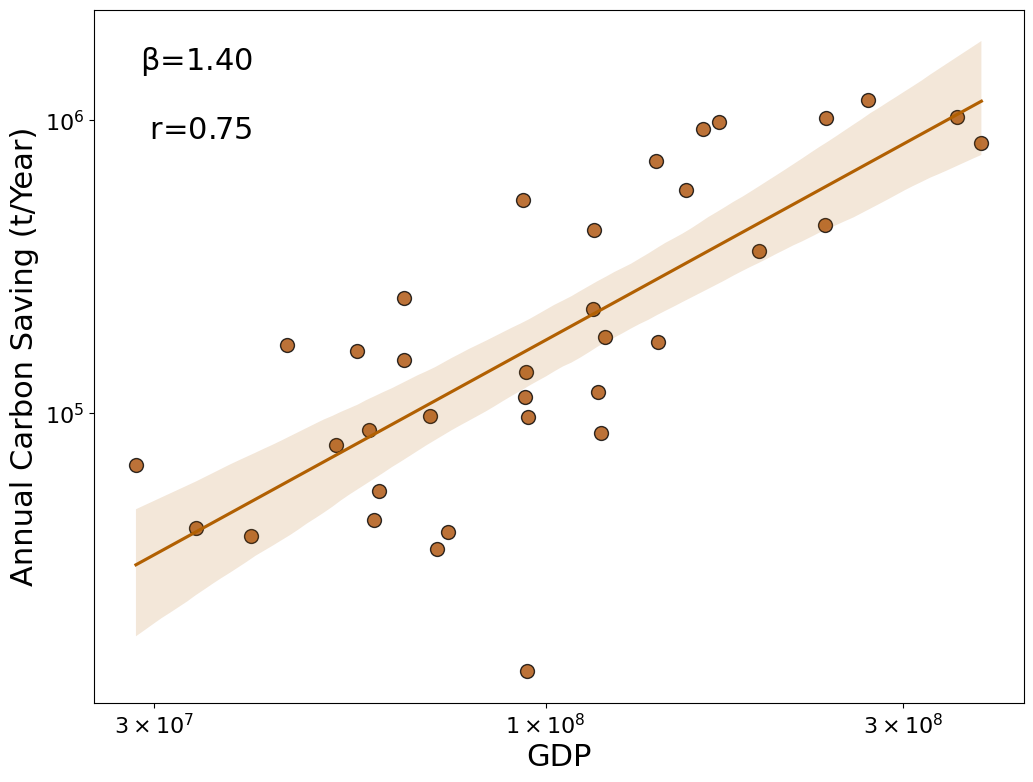

In [28]:
### scaling
import seaborn as sns
from scipy.stats import linregress
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams
import math

rcParams['font.sans-serif'] = ['DejaVu Sans']
rcParams['font.family'] = 'sans-serif'

x = city_debt['Sheet1'][city_debt['Sheet1']['Yearbook_GDP']>0]['Yearbook_GDP']
y = city_debt['Sheet1'][city_debt['Sheet1']['Yearbook_GDP']>0]['carbon_save'].values*365

log_x = np.log10(x)
log_y = np.log10(y)

plt.figure(figsize=(12, 9))

slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)

sns.regplot(x=log_x, y=log_y, scatter=True, label=f'Fit (Exponent={slope:.2f}, r-value={r_value:.2f})',
            scatter_kws={'s': 100, 'edgecolor': 'black', 'linewidth': 1, 'color': '#ac4f06'},
            line_kws={'color': '#b16002'})

plt.xlabel('GDP', fontsize=22)
plt.ylabel('Annual Carbon Saving (t/Year)', fontsize=22)

def log_format(x, pos):
    x = 10**x
    a = x / (10 ** int(np.log10(x)))
    b = int(np.log10(x))
    return f'${a:.0f} \\times 10^{{{b}}}$'

xt = [3*10**7, 10**8, 3*10**8]
xt = [np.log10(m) for m in xt]
plt.xticks(xt, fontsize=16)
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_format))

def log_format_2(x, pos):
    return f'$10^{{{round(x)}}}$'

yt = np.linspace(5, 6, 2)
plt.yticks(yt, fontsize=16)
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_format_2))

plt.text(0.05, 0.95, f'$\\beta$={slope:.2f}\n \n $r$={r_value:.2f}', 
         transform=plt.gca().transAxes, fontsize=22, verticalalignment='top')

Text(0.05, 0.95, '$\\beta$=1.65\n \n $r$=0.69')

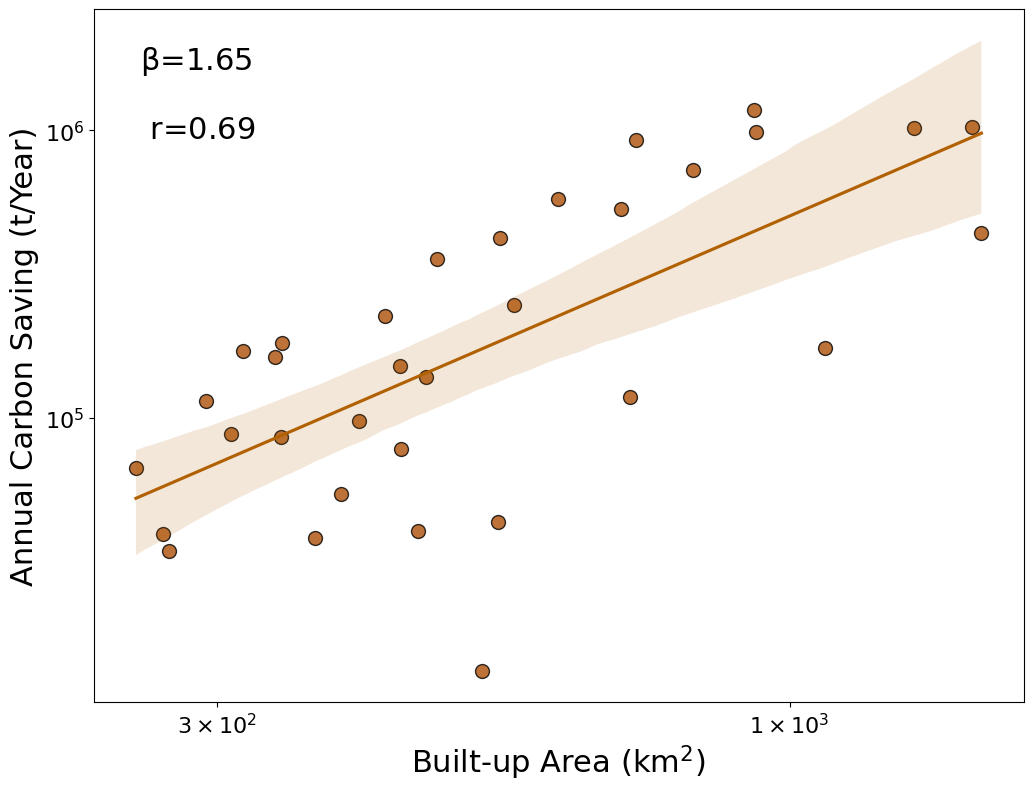

In [29]:
### scaling
import seaborn as sns
from scipy.stats import linregress
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams
import math

rcParams['font.sans-serif'] = ['DejaVu Sans']
rcParams['font.family'] = 'sans-serif'

x = city_debt['Sheet1'][city_debt['Sheet1']['Yearbook_built_area']>0]['Yearbook_built_area']
y = city_debt['Sheet1'][city_debt['Sheet1']['Yearbook_built_area']>0]['carbon_save'].values*365

log_x = np.log10(x)
log_y = np.log10(y)

plt.figure(figsize=(12, 9))

slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)

sns.regplot(x=log_x, y=log_y, scatter=True, label=f'Fit (Exponent={slope:.2f}, r-value={r_value:.2f})',
            scatter_kws={'s': 100, 'edgecolor': 'black', 'linewidth': 1, 'color': '#ac4f06'},
            line_kws={'color': '#b16002'})

plt.xlabel('Built-up Area ($km^2$)', fontsize=22)
plt.ylabel('Annual Carbon Saving (t/Year)', fontsize=22)

def log_format(x, pos):
    x = 10**x
    a = x / (10 ** int(np.log10(x)))
    b = int(np.log10(x))
    return f'${a:.0f} \\times 10^{{{b}}}$'

xt = [3*10**2, 10**3]
xt = [np.log10(m) for m in xt]
plt.xticks(xt, fontsize=16)
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_format))

def log_format_2(x, pos):
    return f'$10^{{{round(x)}}}$'

yt = np.linspace(5, 6, 2)
plt.yticks(yt, fontsize=16)
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_format_2))

plt.text(0.05, 0.95, f'$\\beta$={slope:.2f}\n \n $r$={r_value:.2f}', 
         transform=plt.gca().transAxes, fontsize=22, verticalalignment='top')

In [30]:
import pandas as pd
import networkx as nx
from tqdm import tqdm
from openpyxl import Workbook

city_list_chn = '北京、上海、深圳、长沙、天津、杭州、郑州、成都、长春、大连、武汉、济南、南京、无锡、青岛、西安、常州、广州、福州、合肥、昆明、厦门、贵阳、沈阳、南昌、宁波、徐州、重庆、哈尔滨、兰州、乌鲁木齐、南宁、东莞、苏州、石家庄'
city_list_chn = city_list_chn.split('、')
chn2en= {'东莞': 'Dongguan',   '台州': 'Taizhou',   '南宁': 'Nanning',   '佛山': 'Foshan',   '温州': 'Wenzhou',   '南通': 'Nantong',   '兰州': 'Lanzhou',   '宁波': 'Ningbo',   '南京': 'Nanjing',   '苏州': 'Suzhou',   '太原': 'Taiyuan',   '武汉': 'Wuhan',   '无锡': 'Wuxi',   '郑州': 'Zhengzhou',   '珠海': 'Zhuhai',   '北京': 'Beijing',   '长春': 'Changchun',   '长沙': 'Changsha',   '常州': 'Changzhou',   '成都': 'Chengdu',   '大连': 'Dalian',   '福州': 'Fuzhou',   '广州': 'Guangzhou',   '杭州': 'Hangzhou',   '济南': 'Jinan',   '昆明': 'Kunming',   '青岛': 'Qingdao',   '上海': 'Shanghai',   '深圳': 'Shenzhen',   '石家庄': 'Shijiazhuang',   '天津': 'Tianjin',   '西安': "Xi'an",   '厦门': 'Xiamen',   '徐州': 'Xuzhou',   '沈阳': 'Shenyang',   '南昌': 'Nanchang',   '洛阳': 'Luoyang',   '呼和浩特': 'Hohhot',   '乌鲁木齐': 'Urumqi', '重庆': 'Chongqing', '哈尔滨': 'Harbin', '合肥': 'Hefei', '贵阳': 'Guiyang'}
city_list_en = [chn2en[city] for city in city_list_chn]  

wb = Workbook()
ws = wb.active
column_names = ['city', 'station_num', 'edge_num', 'alpha', 'beta', 'gamma', 'maximum_shortest_path','phi']
ws.append(column_names)

for city_en_short in tqdm(city_list_en):
    station_set = []
    edge_set = []

    if city_en_short in ['Shanghai', 'Tianjin', 'Chongqing', 'Beijing']:
        city_en = city_en_short + ' Municipality'
    else:
        city_en = city_en_short

    with open('subway_boundary_file/subway_built_year/fenduan_{}.json'.format(city_en),
            'r') as f:
        fenduan_info = json.load(f)

    month_range = [m for m in fenduan_info['2019'] if 12 in eval(m)][0]
    stations = fenduan_info['2019'][month_range]

    subway_years = pd.read_excel('subway_boundary_file/subway_built_year/subway_years_{}.xlsx'.format(city_en_short))
    subway_stations_years = pd.read_excel('subway_boundary_file/subway_built_year/subway_stations_years_{}.xlsx'.format(city_en_short), sheet_name=None)
    lines = subway_years[subway_years['remove']!=1]['地铁线路'].unique()

    for line in lines:
        if line not in stations:
            continue
        duan_set = [list(m) for m in eval(stations[line])]
        for duan in duan_set:
            station_set += duan

        for duan in duan_set:
            idx_list = []
            for station in duan:
                try:
                    idx = subway_stations_years[line][subway_stations_years[line]['站点']==station].index[0]
                except:
                    print(station)
                    continue
                idx_list.append(idx)
            max_idx, min_idx = max(idx_list), min(idx_list)
        
        for i in range(min_idx, max_idx):
            edge_set.append((subway_stations_years[line].iloc[i]['站点'], subway_stations_years[line].iloc[i+1]['站点']))
            edge_set.append((subway_stations_years[line].iloc[i+1]['站点'], subway_stations_years[line].iloc[i]['站点']))

    edge_set = set(edge_set)
    station_set = set(station_set)

    e, v = len(edge_set)//2, len(station_set) 

    alpha = (e-v+1)/(2*v-5)
    beta = e/v
    gamma = e/(3*v-6) 
    
    G = nx.Graph()
    G.add_weighted_edges_from([edge+tuple([1]) for edge in edge_set])
    shortest_path_lengths = dict(nx.floyd_warshall(G))
    maximum_shortest_path = 0
    for station in shortest_path_lengths:
        if max(shortest_path_lengths[station].values()) > maximum_shortest_path:
            maximum_shortest_path = max(shortest_path_lengths[station].values())
    ws.append([city_en_short, v, e, alpha, beta, gamma, maximum_shortest_path, e/maximum_shortest_path])
wb.save("route_api_hours/network_indicators.xlsx")

100%|██████████| 35/35 [00:07<00:00,  4.65it/s]


In [31]:
network_indicators = pd.read_excel('route_api_hours/network_indicators.xlsx')
sheet = pd.merge(network_indicators, city_debt['Sheet1'], left_on='city', right_on='City', how='outer')

Text(0.05, 0.95, '$\\beta$=1.80\n \n $r$=0.89')

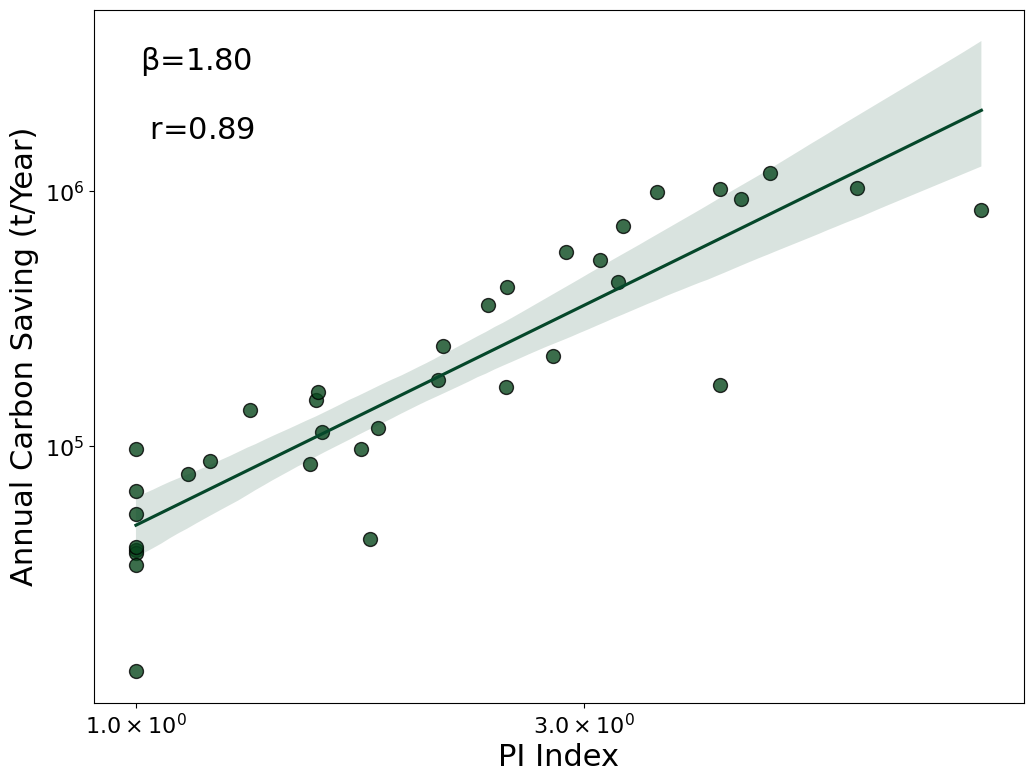

In [32]:
### scaling
import seaborn as sns
from scipy.stats import linregress
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams
import math

rcParams['font.sans-serif'] = ['DejaVu Sans']
rcParams['font.family'] = 'sans-serif'

x = sheet[sheet['phi']>0]['phi']
y = sheet[sheet['phi']>0]['carbon_save'].values*365

log_x = np.log10(x)
log_y = np.log10(y)

plt.figure(figsize=(12, 9))

slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)

sns.regplot(x=log_x, y=log_y, scatter=True, label=f'Fit (Exponent={slope:.2f}, r-value={r_value:.2f})',
            scatter_kws={'s': 100, 'edgecolor': 'black', 'linewidth': 1, 'color': '#0a481e'},
            line_kws={'color': '#05472a'})

plt.xlabel('PI Index', fontsize=22)
plt.ylabel('Annual Carbon Saving (t/Year)', fontsize=22)

def log_format(x, pos):
    x = 10**x
    a = x / (10 ** int(np.log10(x)))
    b = int(np.log10(x))
    return f'${a:.1f} \\times 10^{{{b}}}$'

xt = [1*10**0, 3*10**0]
xt = [np.log10(m) for m in xt]
plt.xticks(xt, fontsize=16)
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_format))

def log_format_2(x, pos):
    return f'$10^{{{round(x)}}}$'

yt = np.linspace(5, 6, 2)
plt.yticks(yt, fontsize=16)
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_format_2))

plt.text(0.05, 0.95, f'$\\beta$={slope:.2f}\n \n $r$={r_value:.2f}', 
         transform=plt.gca().transAxes, fontsize=22, verticalalignment='top')

Text(0.05, 0.95, '$\\beta$=19.15\n \n $r$=0.85')

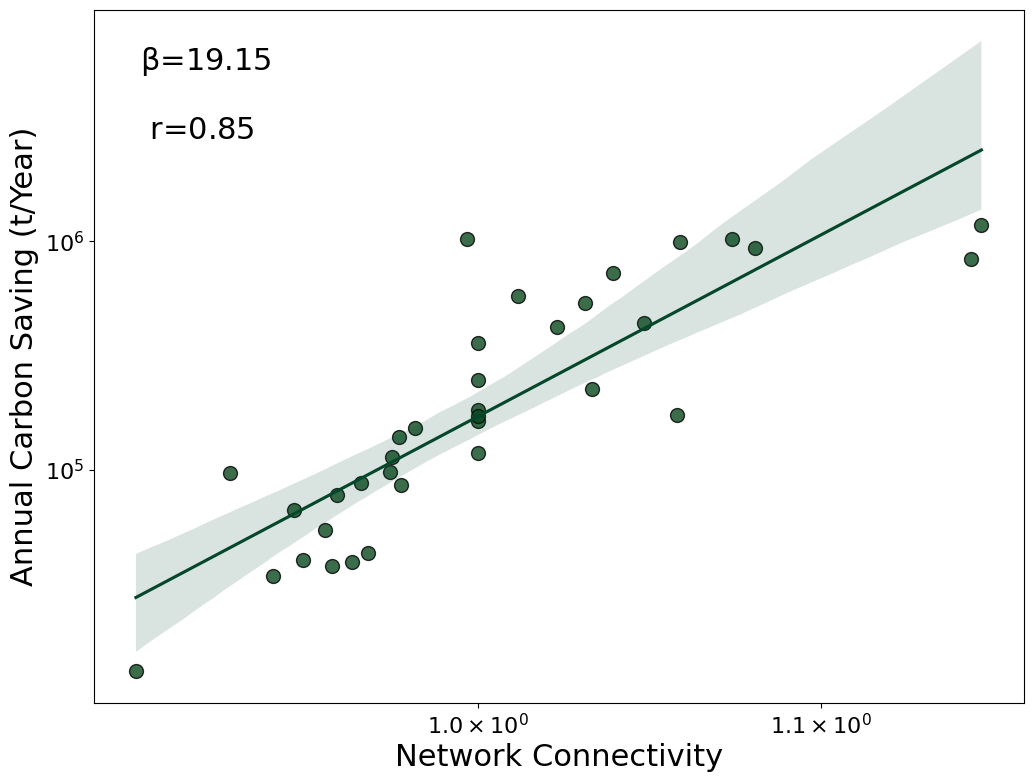

In [33]:
### scaling
import seaborn as sns
from scipy.stats import linregress
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams
import math

rcParams['font.sans-serif'] = ['DejaVu Sans']
rcParams['font.family'] = 'sans-serif'

x = sheet[sheet['beta']>0]['beta']
y = sheet[sheet['beta']>0]['carbon_save'].values*365

log_x = np.log10(x)
log_y = np.log10(y)

plt.figure(figsize=(12, 9))

slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)

sns.regplot(x=log_x, y=log_y, scatter=True, label=f'Fit (Exponent={slope:.2f}, r-value={r_value:.2f})',
            scatter_kws={'s': 100, 'edgecolor': 'black', 'linewidth': 1, 'color': '#0a481e'},
            line_kws={'color': '#05472a'})

plt.xlabel('Network Connectivity', fontsize=22)
plt.ylabel('Annual Carbon Saving (t/Year)', fontsize=22)

def log_format(x, pos):
    x = 10**x
    a = x / (10 ** int(np.log10(x)))
    b = int(np.log10(x))
    return f'${a:.1f} \\times 10^{{{b}}}$'

xt = [1*10**0, 1.1]
xt = [np.log10(m) for m in xt]
plt.xticks(xt, fontsize=16)
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_format))

def log_format_2(x, pos):
    return f'$10^{{{round(x)}}}$'

yt = np.linspace(5, 6, 2)
plt.yticks(yt, fontsize=16)
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_format_2))

plt.text(0.05, 0.95, f'$\\beta$={slope:.2f}\n \n $r$={r_value:.2f}', transform=plt.gca().transAxes, fontsize=22, verticalalignment='top')

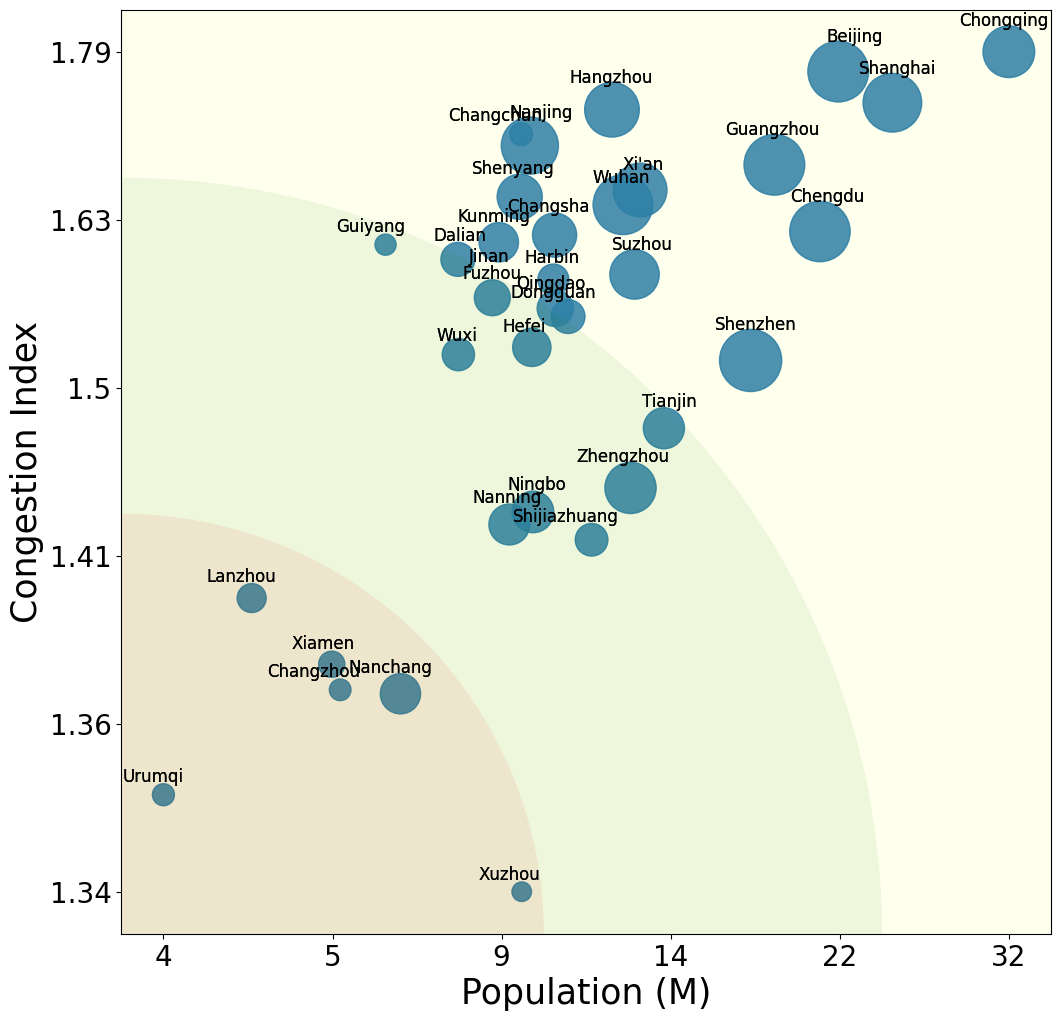

In [40]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge

x = city_debt['Sheet1']['Yearbook_popu']
y = city_debt['Sheet1']['Congestion']
x_save, y_save = x, y
z = np.log(city_debt['Sheet1']['carbon_save'])
names = city_debt['Sheet1']['City']

norm_x = (x - np.min(x)) / (np.max(x) - np.min(x))
norm_y = (y - np.min(y)) / (np.max(y) - np.min(y))
norm_y = np.sqrt(norm_y)
norm_x = np.sqrt(norm_x)
norm_z = (z - np.min(z)) / (np.max(z) - np.min(z))

sizes = norm_z**1.5 * 2000

plt.figure(figsize=(12, 12))

name2loc = {}
scatter = plt.scatter(norm_x, norm_y, s=sizes, alpha=0.3, c='steelblue')
for i, (x, y, name, size) in enumerate(zip(norm_x, norm_y, names, sizes)):
    scale = (size/max(sizes))**0.4*1.8
    if len(name) < 5:
        name2loc[name] = (x+0.03*scale-0.01, y+0.015*scale)
        plt.text(x+0.03*scale-0.01, y+0.015*scale, name, fontsize=12, ha='right')
    elif len(name) < 6:
        name2loc[name] = (x+0.03*scale-0.02, y+0.015*scale)
        plt.text(x+0.03*scale-0.02, y+0.015*scale, name, fontsize=12, ha='right')
    else:
        name2loc[name] = (x+0.03*scale, y+0.02*scale)
        plt.text(x+0.03*scale, y+0.02*scale, name, fontsize=12, ha='right')

scatter = plt.scatter(norm_x, norm_y, s=sizes, alpha=0.8)
for i, (x, y, name, size) in enumerate(zip(norm_x, norm_y, names, sizes)):
    x, y = name2loc[name]
    plt.text(x, y, name, fontsize=12, ha='right')
    

plt.xlabel('Population (M)', fontsize=25)
plt.ylabel('Congestion Index', fontsize=25)
plt.ylim(-0.05, 1.05)
plt.xlim(-0.05, 1.05)

center_x = -0.05
center_y = -0.05
width = 0.5  
height = width*ratio  
angle = 0  
theta1 = 0  
theta2 = 90  

wedge = Wedge(center=(center_x, center_y), r=width, theta1=theta1, theta2=theta2, facecolor='red', alpha=0.07)
plt.gca().add_patch(wedge)

center_x = -0.05
center_y = -0.05
width = 0.90  
height = width*ratio  
angle = 0  
theta1 = 0  
theta2 = 90  

wedge1 = Wedge(center=(center_x, center_y), r=width, theta1=theta1, theta2=theta2, facecolor='green', alpha=0.07)
plt.gca().add_patch(wedge1)

center_x = -0.05
center_y = -0.05
width = 1.65  
height = width*ratio 
angle = 0  
theta1 = 0  
theta2 = 90  

wedge2 = Wedge(center=(center_x, center_y), r=width, theta1=theta1, theta2=theta2, facecolor='yellow', alpha=0.07)
plt.gca().add_patch(wedge2)

xt = np.linspace(0, 1, 6)
x_ticks = [round((m**2*(np.max(x_save)-np.min(x_save))+np.min(x_save)) / 1e6) for m in xt]
plt.xticks(xt, x_ticks)

yt = np.linspace(0, 1, 6)
y_ticks = [round((m**2*(np.max(y_save)-np.min(y_save))+np.min(y_save)), 2) for m in yt]
plt.yticks(yt, y_ticks)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

5. line-level analysis

In [48]:
import pandas as pd

carbon_debt_lines = pd.read_excel('route_api_hours/20240625/lines_carbon_debt_noncalibrated.xlsx', sheet_name=None)
city_type_indicator = pd.read_excel('route_api_hours/line_indicator_0625.xlsx')
city_line_indicator = pd.read_excel('route_api_hours/city_line_indicator_panel.xlsx')
city_indicator = pd.read_excel('route_api_hours/city_indicator_panel.xlsx')
city_indicator['month'] = city_indicator['month'].apply(lambda x: eval(x)[0])
city_type_indicator = city_type_indicator[['city', 'line', 'line_type', 'line_role', 'fork', 'round']]
city_line_indicator = pd.merge(city_line_indicator, city_type_indicator, on=['city', 'line'])

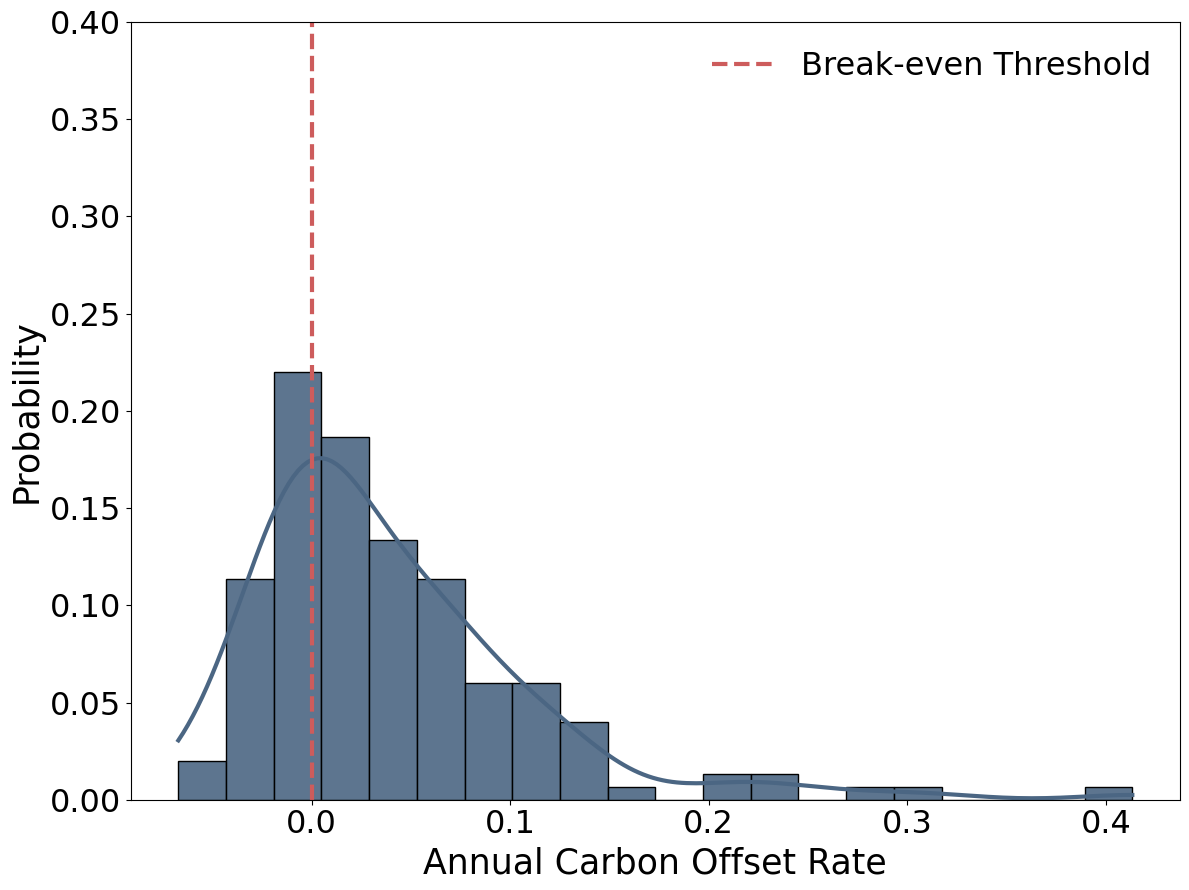

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

carbon_debt_lines['Carbon_save_rate'] = (carbon_debt_lines['Current Carbon Save'] - carbon_debt_lines['Current Operation']) * 365 / carbon_debt_lines['Total Construction']

plt.figure(figsize=(12, 9))
sns.histplot(carbon_debt_lines['Carbon_save_rate'], bins=20, 
             stat='probability', color='#4b6683', alpha=0.9, kde=True, 
             line_kws={'color': '#4b6683', 'lw': 3}, edgecolor='black')

plt.xlabel('Annual Carbon Offset Rate', fontsize=25)
plt.ylabel('Probability', fontsize=25)

plt.axvline(x=0, color='indianred', linestyle='--', linewidth=3, label='Break-even Threshold')

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.legend(fontsize=23, frameon=False)
plt.ylim(0, 0.4)

plt.tight_layout()
plt.show()


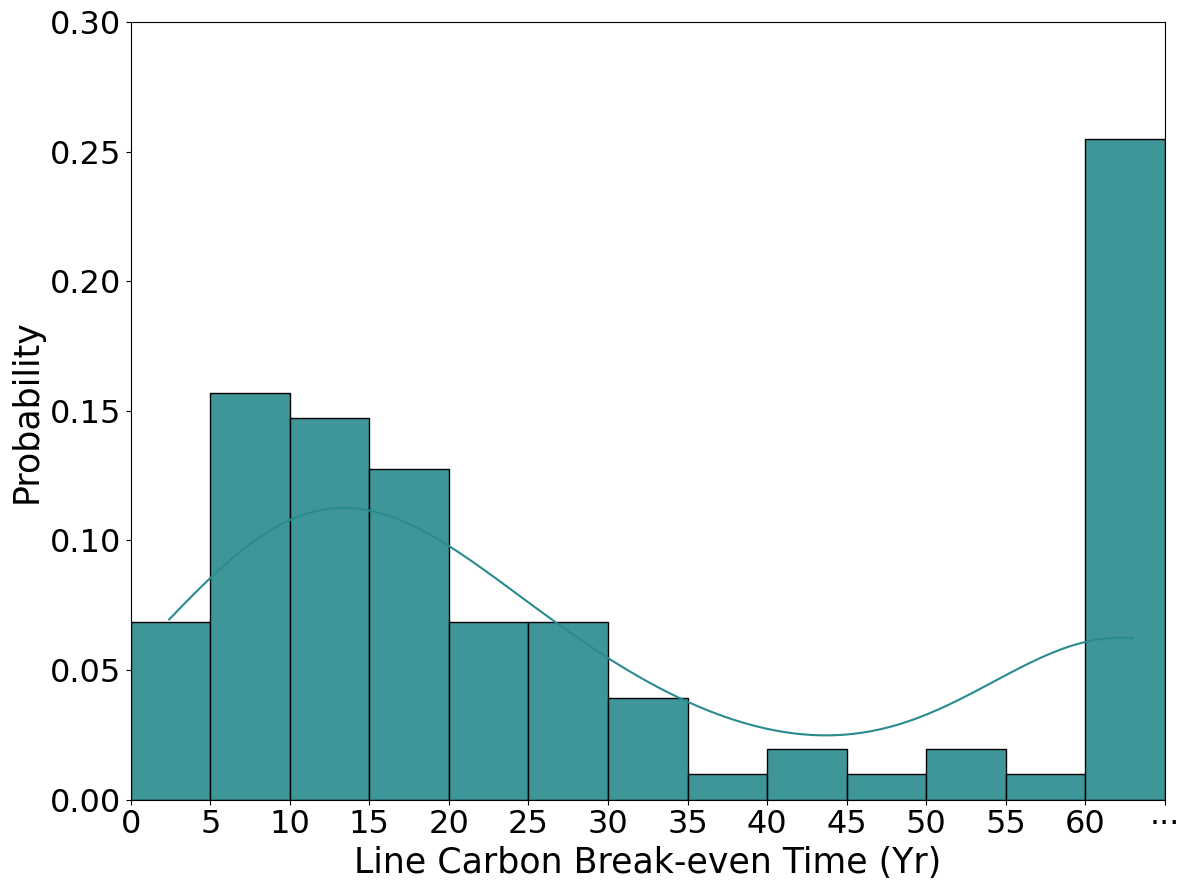

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

carbon_debt_lines['breakeven_time'] = carbon_debt_lines['Total Construction'] / 365 / (carbon_debt_lines['Current Carbon Save'] - carbon_debt_lines['Current Operation'])
carbon_debt_lines['breakeven_time'] = carbon_debt_lines['breakeven_time'].apply(lambda x: min(x, 63))

bins = list(range(0, 66, 5))

plt.figure(figsize=(12, 9))
sns.histplot(carbon_debt_lines[carbon_debt_lines['breakeven_time'] > 0]['breakeven_time'], bins=bins, stat='probability', color='#298b8e', alpha=0.9,kde=True)

plt.xlabel('Line Carbon Break-even Time (Yr)', fontsize=25)
plt.ylabel('Probability', fontsize=25)

plt.xticks(ticks=list(range(0, 66, 5)), labels=[str(i) if i != 65 else '···' for i in range(0, 66, 5)], fontsize=23)
plt.yticks(fontsize=23)
plt.xlim(0, 65)
plt.ylim(0, 0.3)

plt.tight_layout()
plt.show()

In [54]:
import pandas as pd

city_line_indicator = pd.read_excel('route_api_hours/city_line_indicator_panel.xlsx')
city_indicator = pd.read_excel('route_api_hours/city_indicator_panel.xlsx')
city_indicator['month'] = city_indicator['month'].apply(lambda x: eval(x)[0])
carbon_debt_lines = pd.read_excel('route_api_hours/20240625/lines_carbon_debt_noncalibrated_panel.xlsx', sheet_name=None)
city_type_indicator = pd.read_excel('route_api_hours/line_indicator_0625.xlsx')
city_type_indicator = city_type_indicator[['city', 'line', 'line_type', 'line_role', 'fork', 'round']]
city_line_indicator = pd.merge(city_line_indicator, city_type_indicator, on=['city', 'line'])

In [55]:
excel_list = []
for city in carbon_debt_lines:
    carbon_debt_lines[city]['city'] = city
    excel_list.append(carbon_debt_lines[city])

carbon_debt_lines = pd.concat(excel_list, axis=0)
carbon_debt_lines['Year'] = carbon_debt_lines['Year'].apply(lambda x: int(x))

carbon_debt_lines.columns = ['city', 'line', 'Total Construction',  'Current Carbon Save', 'Current Operation','year', 'month', 'Mileage', 'Station Num']
carbon_debt_lines['month'] = carbon_debt_lines['month'].apply(lambda x: int(eval(x)[0]))
carbon_debt_lines['carbon_save_rate'] = (carbon_debt_lines['Current Carbon Save']-carbon_debt_lines['Current Operation'])/carbon_debt_lines['Total Construction']

carbon_debt_lines = pd.merge(carbon_debt_lines, city_line_indicator, on=['city', 'line', 'year', 'month'])
carbon_debt_lines['carbon_save_rate_mileage'] = (carbon_debt_lines['Current Carbon Save']-carbon_debt_lines['Current Operation'])/carbon_debt_lines['subway_line_mileage']*1e3
carbon_debt_lines['break_even_time'] = carbon_debt_lines['Total Construction']/(carbon_debt_lines['Current Carbon Save']-carbon_debt_lines['Current Operation'])/365

carbon_debt_lines = pd.merge(carbon_debt_lines, city_indicator, on=['city', 'year','month'])

carbon_debt_lines = carbon_debt_lines.dropna()

In [56]:
line_information = carbon_debt_lines
line_information['gdp_pc'] = line_information['gdp']/line_information['popu']
line_information['popu_density'] = line_information['popu']/line_information['area']
line_information['average_closeness_scaled'] = line_information.apply(lambda row: row['average_closeness']*row['maximum_shortest_path'], axis=1)

In [57]:
line_information['line_id'] = line_information.apply(lambda row: row['city']+row['line'], axis=1)
line2id = dict(zip(line_information['line_id'].unique(), range(len(line_information['line_id'].unique()))))
line_information['line_id'] = line_information['line_id'].apply(lambda x: line2id[x])

In [58]:
### panel OLS

import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linearmodels.panel import PanelOLS, RandomEffects

line_information['Current Carbon Save Rate'] = line_information['Current Carbon Save']/line_information['Mileage']*365  
line_information['Station_density'] = line_information['subway_line_num_station']/line_information['Mileage']*1e3
line_information['Transfer_density'] = line_information['subway_line_num_transfer']/line_information['Mileage']*1e3
line_information['age'] = line_information['year'] - line_information['open_year']
line_information['time'] = line_information['year']+line_information['month']/12    
data = line_information[['Current Carbon Save Rate', 'line_id', 'time', 'Station_density', 'Transfer_density', 'Mileage','line_type', 'line_role', 'fork', \
                         'subway_line_num',  'subway_station_num',  'subway_line_mileage', 'subway_station_exchange_num','popu_worldpop', \
                            'average_degree', 'average_betweenness_centrality', 'average_closeness', 'population']]     

data['Mileage'] = data['Mileage']/1e3
data['population'] = data['population']/1e6
data['popu_worldpop'] = data['popu_worldpop']/1e6

categorical_columns = ['line_type', 'line_role', 'fork']
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True, dtype=int)

data_encoded = data_encoded.dropna()
data_encoded = data_encoded.set_index(['line_id', 'time'])
y = data_encoded['Current Carbon Save Rate']
X = data_encoded.drop(columns=['Current Carbon Save Rate'])
X = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
threshold = 10
filtered_features = vif_data[vif_data["VIF"] < threshold]["feature"]
X_filtered = X[filtered_features]

print("Remaining Variables:", X_filtered.columns)
X_filtered = sm.add_constant(X_filtered)
model_rem = RandomEffects(y, X_filtered)
results_rem = model_rem.fit()
print(results_rem.summary)

Remaining Variables: Index(['Station_density', 'Transfer_density', 'popu_worldpop',
       'average_degree', 'average_betweenness_centrality', 'average_closeness',
       'population', 'line_type_2', 'line_type_3', 'line_type_4',
       'line_role_2', 'fork_1'],
      dtype='object')
                           RandomEffects Estimation Summary                           
Dep. Variable:     Current Carbon Save Rate   R-squared:                        0.5640
Estimator:                    RandomEffects   R-squared (Between):              0.2235
No. Observations:                      1102   R-squared (Within):               0.6028
Date:                      Wed, Apr 23 2025   R-squared (Overall):              0.2662
Time:                              21:49:16   Log-likelihood                   -1381.3
Cov. Estimator:                  Unadjusted                                           
                                              F-statistic:                      117.39
Entities:          

/tmp/ipykernel_1308368/285905354.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Mileage'] = data['Mileage']/1e3
/tmp/ipykernel_1308368/285905354.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['population'] = data['population']/1e6
/tmp/ipykernel_1308368/285905354.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

1102


/tmp/ipykernel_1308368/1513696997.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Carbon_save_rate_no_operation', y='line_type', data=data, ax=ax, palette=['#909090', '#0095FF', '#019092', '#6FDCB5'])


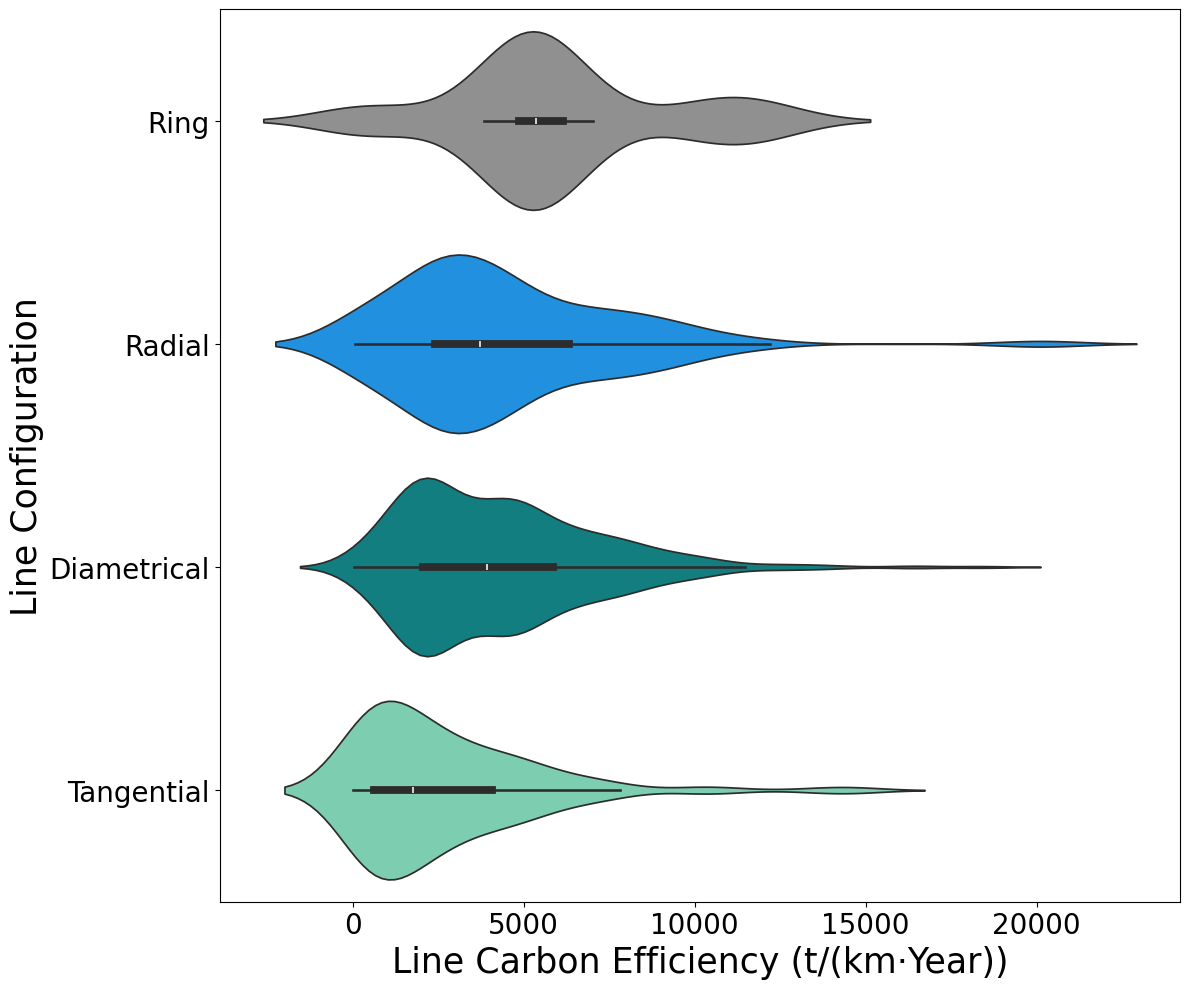

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

carbon_debt_lines['Carbon_save_rate_no_operation'] = carbon_debt_lines['Current Carbon Save'] * 365 / carbon_debt_lines['Mileage']*1e3
print(len(carbon_debt_lines))
data1 = carbon_debt_lines[carbon_debt_lines['line_type'] == 4]['Carbon_save_rate_no_operation']
data2 = carbon_debt_lines[carbon_debt_lines['line_type'] == 1]['Carbon_save_rate_no_operation']
data3 = carbon_debt_lines[carbon_debt_lines['line_type'] == 2]['Carbon_save_rate_no_operation']
data4 = carbon_debt_lines[carbon_debt_lines['line_type'] == 3]['Carbon_save_rate_no_operation']

data = pd.DataFrame({
    'Carbon_save_rate_no_operation': np.concatenate([data1, data2, data3, data4]),
    'line_type': ['Ring'] * len(data1) + ['Radial'] * len(data2) + ['Diametrical'] * len(data3) + ['Tangential'] * len(data4)
})

fig, ax = plt.subplots(figsize=(12, 10))

sns.violinplot(x='Carbon_save_rate_no_operation', y='line_type', data=data, ax=ax, palette=['#909090', '#0095FF', '#019092', '#6FDCB5'])

ax.set_xlabel('Line Carbon Efficiency (t/(km·Year))', fontsize=25)
ax.set_ylabel('Line Configuration', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.show()


/tmp/ipykernel_1308368/1236917664.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Carbon_save_rate_no_operation', y='line_role', data=data, ax=ax, palette=['#0095FF', '#019092',])


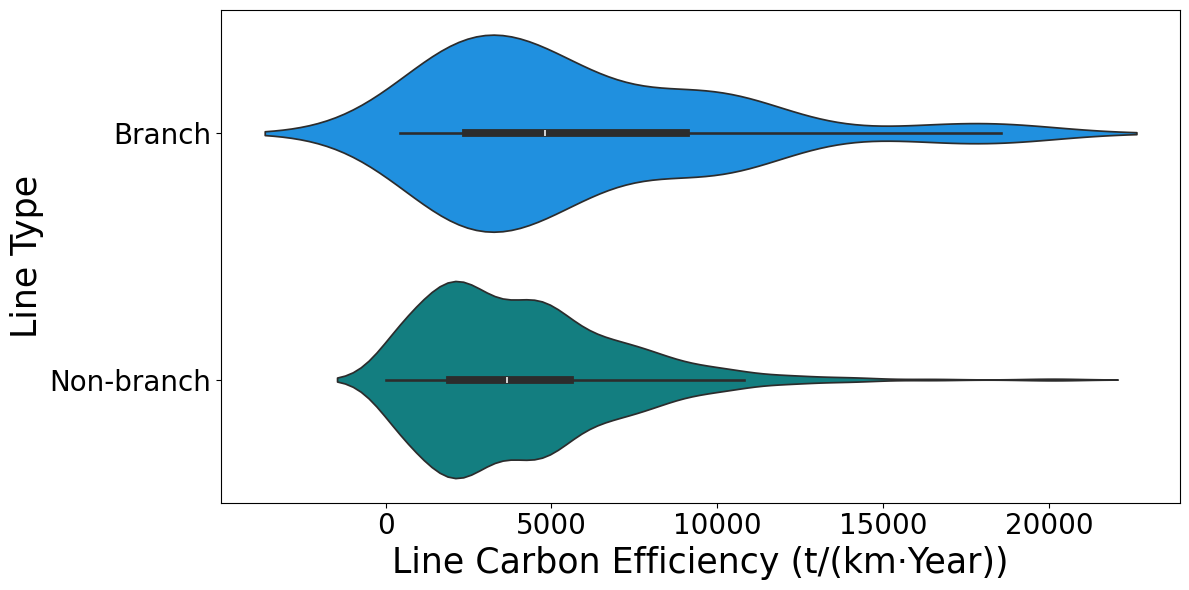

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

carbon_debt_lines['Carbon_save_rate_no_operation'] = carbon_debt_lines['Current Carbon Save'] *365 / carbon_debt_lines['Mileage'] *1e3
data1 = carbon_debt_lines[carbon_debt_lines['fork'] == 1]['Carbon_save_rate_no_operation']
data2 = carbon_debt_lines[carbon_debt_lines['fork'] == 0]['Carbon_save_rate_no_operation']

data = pd.DataFrame({
    'Carbon_save_rate_no_operation': np.concatenate([data1, data2]),
    'line_role': ['Branch'] * len(data1) + ['Non-branch'] * len(data2)
})

fig, ax = plt.subplots(figsize=(12, 6))
sns.violinplot(x='Carbon_save_rate_no_operation', y='line_role', data=data, ax=ax, palette=['#0095FF', '#019092',])

ax.set_xlabel('Line Carbon Efficiency (t/(km·Year))', fontsize=25)
ax.set_ylabel('Line Type', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.show()


/tmp/ipykernel_1308368/2813405362.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Carbon_save_rate_no_operation', y='line_role', data=data, ax=ax, palette=['#909090', '#6FDCB5'])


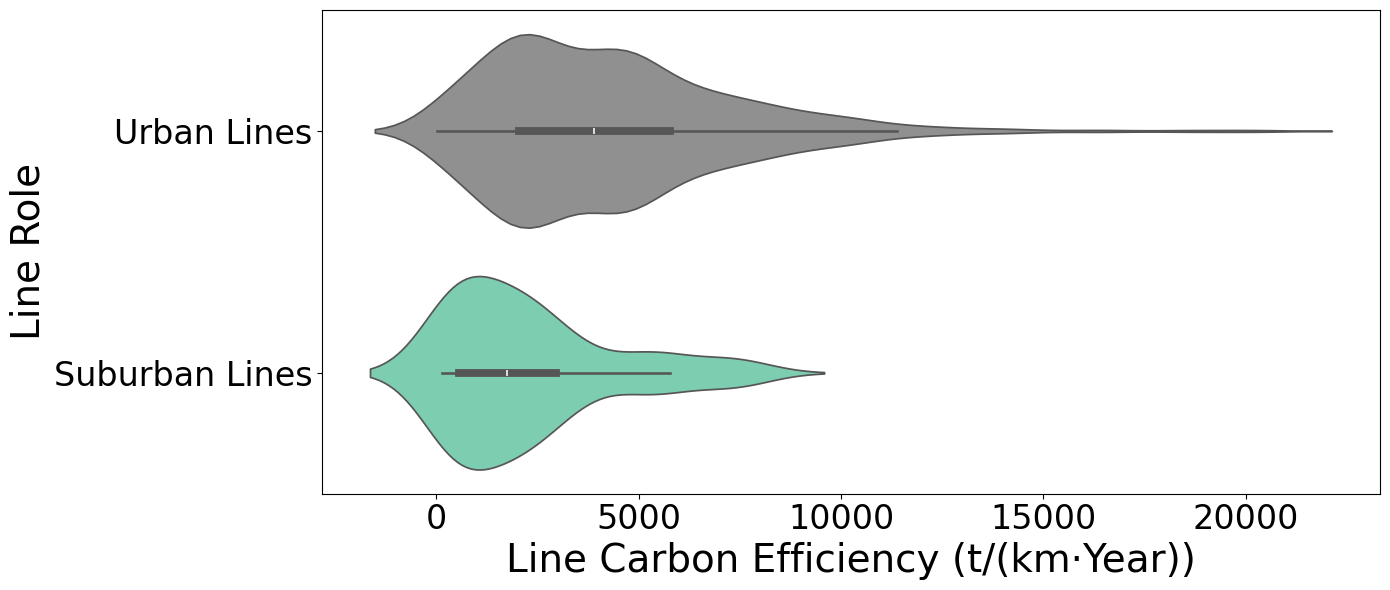

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

carbon_debt_lines['Carbon_save_rate_no_operation'] = carbon_debt_lines['Current Carbon Save'] * 365 / carbon_debt_lines['Mileage']*1e3
data1 = carbon_debt_lines[carbon_debt_lines['line_role'] == 1]['Carbon_save_rate_no_operation']
data2 = carbon_debt_lines[carbon_debt_lines['line_role'] == 2]['Carbon_save_rate_no_operation']

data = pd.DataFrame({
    'Carbon_save_rate_no_operation': np.concatenate([data1, data2]),
    'line_role': ['Urban Lines'] * len(data1) + ['Suburban Lines'] * len(data2)
})

fig, ax = plt.subplots(figsize=(14, 6))

sns.violinplot(x='Carbon_save_rate_no_operation', y='line_role', data=data, ax=ax, palette=['#909090', '#6FDCB5'])

ax.set_xlabel('Line Carbon Efficiency (t/(km·Year))', fontsize=28)
ax.set_ylabel('Line Role', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.tight_layout()
plt.show()


In [62]:
import scipy.stats as stats
import numpy as np

carbon_debt_lines['Carbon_save_rate_no_operation'] = carbon_debt_lines['Current Carbon Save'] *365 / carbon_debt_lines['Mileage']
tmp = carbon_debt_lines
group1 = tmp[tmp['line_role'] == 1]['Carbon_save_rate_no_operation']
group2 = tmp[tmp['line_role'] == 2]['Carbon_save_rate_no_operation']
print(len(group1), len(group2))

t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)

print(f't-statistic: {t_stat}, p-value: {p_value}')
if p_value < 0.05:
    print("Reject Null Hypothesis: The two groups are significantly different")
else:
    print("Fail to Reject Null Hypothesis: The two groups are not significantly different")

1033 69
t-statistic: 7.650680151506401, p-value: 2.2028552614916553e-11
Reject Null Hypothesis: The two groups are significantly different
